# **Intro**

🔗 Соревнование: https://www.kaggle.com/competitions/teta-ml-1-2025/leaderboard
🏆 F1 Score на лидерборде: 0.788482 — бейзлайн побит!

В рамках решения задачи предсказания мошеннических транзакций (фрод) была проведена комплексная работа, включающая обработку данных, выбор алгоритма, его обучение и валидацию. Опишем основные этапы:

1. **Обработка данных**:
   - Выполнено разделение исходного датасета `train` на две независимые выборки: `X_train` и `X_test`. Это позволило проводить преобразования независимо для каждой выборки, избегая утечки данных.
   - Проведен детальный анализ данных (EDA), выявлены распределения числовых и категориальных признаков, а также потенциальные выбросы.
   - В рамках Feature Engineering добавлены новые признаки, такие как временные (`is_night`, `is_weekday`, `fraud_rate_by_day`), географические (`hav_dist_1`, `bearing_degree_1`) и агрегированные (`merchant_avg_amount`, `merchant_transaction_count`). Для кодирования категориальных признаков использован метод CatBoost Encoder.
   - Применены методы нормализации (логарифмирование) для числовых признаков с длинными хвостами (`amount`, `population_city`).

2. **Базовый алгоритм**:
   - Был выбран LGBMClassifier
   - F1 Score: 0.62
   - Проведен расчет и применен оптимальный threshold
   - F1 Score: 0.73

3. **Особенности обучения**:
   - Проведена оценка важности признаков: Feature Importance (LightGBM), SHAP (SHapley Additive exPlanations),  Permutation Importance
   - Отобраны топ-10  важных признаков каждого метода: После отбора признаков F1 Score понизился с 0.73, до 0.66, поэтому состав фичей решено было не сокращать.
   - Проведен подбор гиперпараметров с использованием `RandomizedSearchCV`, что позволило найти оптимальные настройки для базовых моделей.


4. **Валидация Базового алгоритма LGBMClassifier**:
   - Проведена стратифицированная кросс-валидация с 5 фолдами на обучающем датасете. Для каждого фолда применялся подобранный scale_pos_weight=1 и оценивался F1-score.
   -  Результаты валидации показали средний F1-score на уровне **0.754**, что подтвердило стабильность модели.
   - Финальное обучение  Базового алгоритма (LGBMClassifier) проведено на всем датасете `train` с использованием найденных параметров и балансировки данных.
   - Результат работы мождели на лидборде  **0.505  - ниже бейзлайна**

   
5. **Выбранный ансамбль моделей (LGBMClassifier, XGBClassifier, CatBoostClassifier) **:
   - Был выбран ансамбль моделей, состоящий из трех градиентных бустингов: `LGBMClassifier`, `XGBClassifier` и `CatBoostClassifier`. Использование ансамбля позволило объединить сильные стороны каждой модели и повысить стабильность предсказаний.
   - Для комбинирования предсказаний моделей использован метод мягкого голосования (`soft voting`), который учитывает вероятности классов.
   - Для учета дисбаланса классов применен метод SMOTE внутри каждого фолда кросс-валидации. Это позволило сбалансировать данные без утечки информации между обучающей и тестовой выборками.

6. **Валидация ансамбля**:
   - Проведена стратифицированная кросс-валидация с 5 фолдами на обучающем датасете. Для каждого фолда применялся SMOTE и оценивался F1-score.
   - Финальное обучение ансамбля проведено на всем датасете `train` с использованием найденных параметров и балансировки данных.
   - Результаты валидации показали средний F1-score на уровне **0.81**, что подтвердило стабильность модели.
   - **Результат работы ансамбля на лидборде 0.788482 -  бейзлайн побит!**
   
7. **ROC-кривая**
    - Для бинаризации предсказаний была попытка использовать оптимальный порог, рассчитанный на основе ROC-кривой.
    - Результат сильно ухудшился, но скорее всего я как-то не так считаю threshold по ROC-кривой для ансамбля
    - F1 Score with optimal threshold: 0.20378197997775305

8. **LightAutoML**
    - Дополнительно был произведен эксперимен с LightAutoML, но применение ансамбля показалоо лучший результат, а так же подтвердилась необходимость предподготовки данных даже пеерд использованием AutoML.
   - Результат AUTO ML с предподготовленным набором фичей, как в ансамбле в соревновании принесло **Счет: 0.728110**
   - AUTO ML с необработанным датасетом train как есть. Оценка в совревновании : 0.524850

---



# **Outro**

Несмотря на достигнутый результат (F1-score = **0.788** на лидерборде), есть несколько направлений для дальнейшего улучшения модели:


### 1. **Идея №1: Добавление новых признаков**
- **Описание**: На основе анализа данных можно добавить новые признаки, такие как вероятность фрода для каждого продавца (`fraud_rate_by_merchant`) или бинарный флаг для транзакций с суммой выше 1100 (такие транзакции практически не содержат фрода).
- **Реализация**:
  - Для расчета `fraud_rate_by_merchant` использовать группировку по продавцам и вычисление доли мошеннических транзакций.
  - Для создания флага проверять условие `amount > 1100`.


### 2. **Идея №2: Улучшение метода отбора признаков**
- **Описание**: В текущем решении использованы все признаки, выбранные по результатам Feature Importance, SHAP и Permutation Importance. Однако часть признаков могла быть избыточной или даже снижать качество модели.
- **Реализация**:
  - Разработать критерий отбора признаков, например, оставлять только те, которые имеют важность выше определенного порога.
  - Проверить влияние каждого признака на метрику с помощью перекрестной проверки.



### 3. **Идея №3: Оптимизация ансамбля**
- **Описание**: Текущий ансамбль использует равные веса для всех моделей. Однако можно улучшить результат, подобрав оптимальные веса для каждой модели.
- **Реализация**:
  - Использовать метод оптимизации (например, GridSearchCV) для подбора весов моделей в ансамбле.
  - Провести дополнительную кросс-валидацию для оценки влияния изменений на стабильность модели.


### 4. **Идея №4: Оптимизация порога классификации через Cost-Sensitive Learning / Weighted Averaging**
- **Описание**: Вместо фиксированного порога 0.5 или порога, найденного по ROC-кривой, использовать **взвешенное усреднение вероятностей** от всех моделей ансамбля с учётом стоимости ошибок (FP и FN).
- **Реализация**:
  - Применить `sklearn.calibration.CalibratedClassifierCV` для калибровки вероятностей.
  - Использовать `scipy.optimize` для поиска порога, **максимизирующего F1-score** на валидации.
  - Реализовать **Cost-Sensitive Learning** через кастомную функцию потерь или параметр `class_weight`, чтобы штрафовать модель за ложные срабатывания сильнее, чем за пропуски.

Это позволит **точнее балансировать precision и recall**, что критично для F1-score в задачах с дисбалансом.


### 5. **Идея №5: Визуализация согласованности методов оценки важности признаков через heatmap**
- **Описание**: Создать **heatmap корреляции** между топ-признаками, отобранными методами SHAP и Permutation Importance, чтобы визуально оценить, насколько они согласованы.
- **Реализация**:
  - Извлечь топ-N признаков (например, top-20) по каждому методу.
  - Построить матрицу корреляции их "рангов важности".
  - Интерпретировать: признаки в "теплом" углу — согласованно важны по обоим методам → высокая уверенность в их значимости.


### 6. **Идея №6: провести Adversarial validation**
После кросс-валидации ожидались стабильные результаты, но при предсказании на тестовой выборке показатели значительно ухудшились. Такое может быть, когда данные (или отдельные признаки) в train и валидации сильно отличаются от тестовой выборки. Это было бы полезно проверить.


 Это могло бы  не только улучшить интерпретируемость, но и помочь выявить стабильные, надёжные признаки для дальнейшего отбора.


In [1]:
%autosave 60

Autosaving every 60 seconds


In [ ]:
import os
from scipy.stats import zscore
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
import seaborn as sns

from tqdm import tqdm
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from sklearn import set_config
set_config(transform_output="pandas")

from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, classification_report

# В соревновани именно f1_score

# 1. Обработка данных

In [ ]:
path_files = '/Users/annashestakova/Documents/ШАД МТС/МЛ 1/Соревнования/'

train = pd.read_csv(path_files + 'train_1.csv')
test = pd.read_csv(path_files + 'test_1.csv')

    Колонки
    transaction_time: дата и время совершения транзакции
    товар: название или идентификатор продавца или торговой точки, где была совершена транзакция
    cat_id: идентификатор категории товара или услуги, к которой относится транзакция
    amount: сумма транзакции
    name_1, name_2: имена, связанные с транзакцией
    gender: пол клиента
    street: название улицы
    one_city: город
    us_state: штат США
    post_code: почтовый индекс
    lat, lon: широта и долгота
    population_city: численность населения города проживания клиента
    jobs: уровень занятости
    merchant_lat, merchant_lon: широта и долгота местоположения продавца или торговой точки
    target: целевая переменная

In [ ]:
 X_train, X_test, y_train, y_test = train_test_split(
    train.drop('target', axis=1),
    train['target'],
    test_size=0.33,
    random_state=42,
    stratify=train['target']
)

# stratify  гарантирует, что пропорции классов в обучающей и тестовой выборках будут такими же, как в исходном датасете .

In [ ]:
# Добавляем target в X_train, нам этот обучающий датасет понадобится в разделе Feature engineering
X_train_with_target = X_train.copy()
X_train_with_target['target'] = y_train

In [ ]:
train.shape, test.shape

((786431, 18), (262144, 17))

In [ ]:
X_train.shape, X_test.shape

((526908, 17), (259523, 17))

# 1.2. Исследовательский анализ данных (EDA)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786431 entries, 0 to 786430
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   transaction_time  786431 non-null  object 
 1   merch             786431 non-null  object 
 2   cat_id            786431 non-null  object 
 3   amount            786431 non-null  float64
 4   name_1            786431 non-null  object 
 5   name_2            786431 non-null  object 
 6   gender            786431 non-null  object 
 7   street            786431 non-null  object 
 8   one_city          786431 non-null  object 
 9   us_state          786431 non-null  object 
 10  post_code         786431 non-null  int64  
 11  lat               786431 non-null  float64
 12  lon               786431 non-null  float64
 13  population_city   786431 non-null  int64  
 14  jobs              786431 non-null  object 
 15  merchant_lat      786431 non-null  float64
 16  merchant_lon      78

In [ ]:
# Преобразование transaction_time в формат даты и времени

# Преобразование transaction_time в datetime
train['transaction_time'] = pd.to_datetime(train['transaction_time'])
print(train['transaction_time'].dtype)

datetime64[ns]


In [ ]:
# Чтобы не забыть сразу преобразуем test,
test['transaction_time'] = pd.to_datetime(test['transaction_time'])
X_train['transaction_time'] = pd.to_datetime(X_train['transaction_time'])
X_test['transaction_time'] = pd.to_datetime(X_test['transaction_time'])

In [ ]:
train.describe().T

,count,mean,min,25%,50%,75%,max,std
transaction_time,786431,2019-08-14 02:20:03.949819392,2019-01-01 00:00:00,2019-05-10 18:48:00,2019-08-13 20:21:00,2019-12-01 12:36:00,2020-03-10 16:08:00,NaN
amount,786431.0,70.241296,1.0,9.65,47.41,83.0,27390.12,161.091489
post_code,786431.0,48802.521336,1257.0,26237.0,48174.0,72042.0,99783.0,26896.564152
lat,786431.0,38.527972,20.0271,34.6205,39.3465,41.8948,66.6933,5.078756
lon,786431.0,-90.224069,-165.6723,-96.798,-87.4769,-80.158,-67.9503,13.75476
population_city,786431.0,89288.530335,23.0,743.0,2456.0,20478.0,2906700.0,302860.007129
merchant_lat,786431.0,38.527301,19.027804,34.72748,39.357665,41.950609,67.441518,5.113222
merchant_lon,786431.0,-90.224508,-166.670132,-96.901593,-87.436919,-80.233429,-66.955996,13.766977
target,786431.0,0.005727,0.0,0.0,0.0,0.0,1.0,0.075461


In [ ]:
train.head(1)

,transaction_time,merch,cat_id,amount,name_1,name_2,gender,street,one_city,us_state,post_code,lat,lon,population_city,jobs,merchant_lat,merchant_lon,target
0,2019-12-27 15:21:00,fraud_Cormier LLC,health_fitness,148.04,Daniel,Martinez,M,8510 Acevedo Burgs,Kent,OR,97033,45.0838,-120.6649,60,Museum education officer,45.042827,-120.709327,0


### 1.2.1 Анализ целевой переменной

Классы сильно несбалансированы (99.4% класса 0, 0.6% класса 1). Это потребует использования специальных методов для работы с дисбалансом.

target
0    0.994273
1    0.005727
Name: proportion, dtype: float64


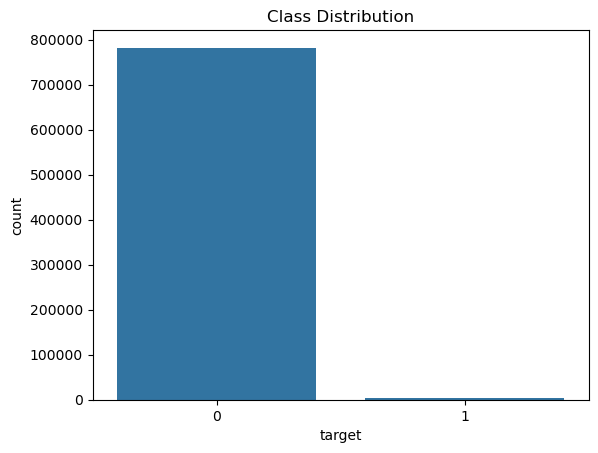

In [ ]:
# Проверим баланс классов

import matplotlib.pyplot as plt
import seaborn as sns

print(train['target'].value_counts(normalize=True))

sns.countplot(x='target', data=train)
plt.title('Class Distribution')
plt.show()

In [ ]:
train.columns

Index(['transaction_time', 'merch', 'cat_id', 'amount', 'name_1', 'name_2',
       'gender', 'street', 'one_city', 'us_state', 'post_code', 'lat', 'lon',
       'population_city', 'jobs', 'merchant_lat', 'merchant_lon', 'target'],
      dtype='object')

In [ ]:
numeric_features = [
    'amount', 'lat', 'lon', 'population_city', 'merchant_lat', 'merchant_lon', 'transaction_time'
]

categorical_features = [
    'merch', 'cat_id', 'gender', 'name_1', 'name_2', 'gender', 'street', 'one_city', 'us_state', 'post_code', 'jobs'
]

### 1.2.2 Анализ числовых признаков

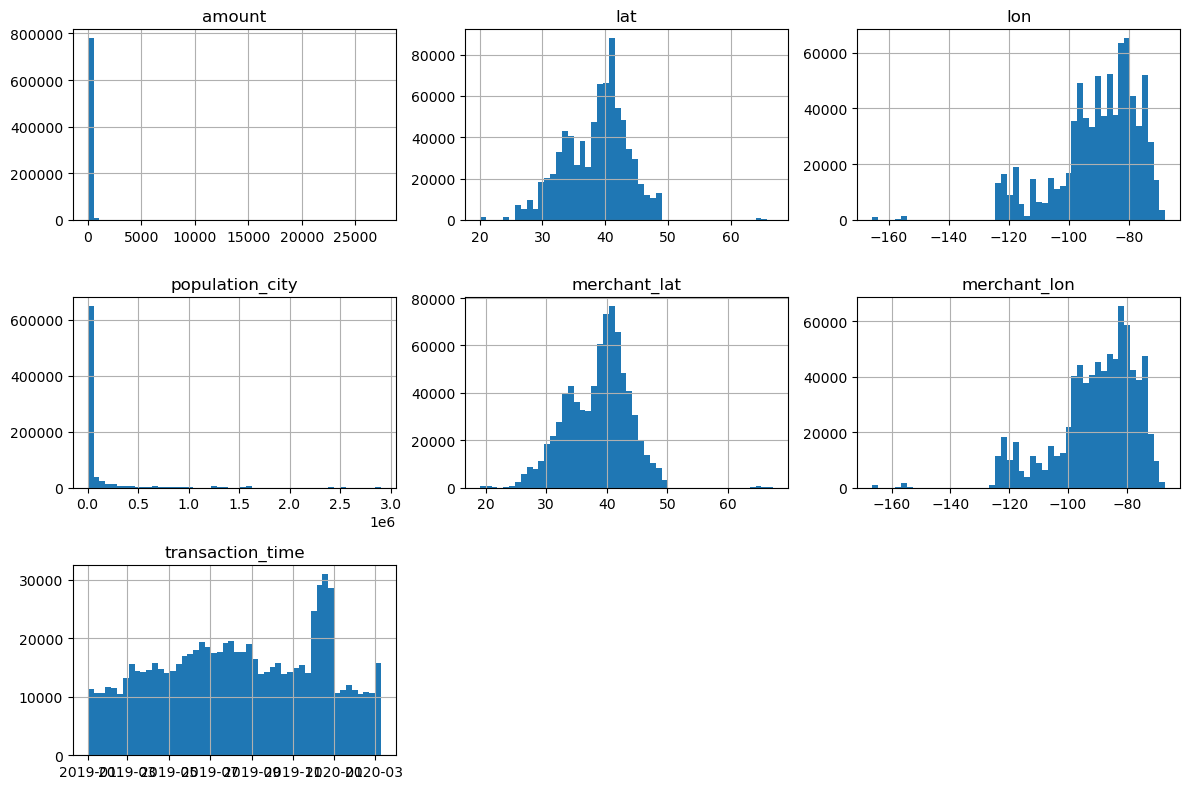

In [ ]:
train[numeric_features].hist(bins=50, figsize=(12, 8))
plt.tight_layout()
plt.show()

На основе предоставленных гистограмм можно сделать следующие выводы:

1. **amount (сумма транзакции)**:
- Распределение сильно **сдвинуто влево** (правостороннее).
- Основная масса транзакций — **на очень малые суммы**, большинство — до 500.


2. **lat и lon (широта и долгота клиентов)**:
- **lat (широта):** значения в диапазоне примерно **от 20 до 50**, что соответствует широтам США.
- **lon (долгота):** диапазон **от -125 до -65**, также соответствует США.
- Распределения имеют форму, характерную для **населения США**, с пиками в более густонаселённых регионах (например, восточное побережье и Калифорния).

3. **merchant_lat и merchant_lon (геолокация продавцов)**:
- Распределения **очень похожи на lat и lon клиентов**, что логично — продавцы и клиенты, вероятно, находятся в тех же регионах.
- Это может указывать на **локальный характер транзакций**, то есть большинство покупок совершаются в географической близости к клиенту.

 4. **population_city (население города)**:
- Очень **сильно скошено вправо**: большинство клиентов живут в небольших городах.
- Есть **единичные случаи** проживания в городах с населением более миллиона (возможно, мегаполисы вроде Нью-Йорка или Лос-Анджелеса).
- Может быть полезно **преобразовать логарифмически** это распределение для моделей.

5. **transaction_time (время транзакции)**
- в целом распределено равномерно с явным пиком в новогодний период 2019-2020 года.
- интересно посмотреть распределения по месяцам/дням/времени и зависимость фрода от временого признака.

Дальнейшие действия:
- Попробую преобразовать признаки с длинными хвостами (amount, population_city) — логарифмирование может помочь.
- Проверить на наличие аномалий или выбросов.
- Проверить зависимости в признаке  **transaction_time**
- Рассчитать **расстояние между клиентом и продавцом** по координатам — это может быть полезным признаком. (то, что мы делали на семинаре)
- Провести **кластеризацию по геолокации** или выделить регионы для анализа транзакционных паттернов.

### 1.2.3 Проверка на выбросы

In [ ]:
numeric_features.remove('transaction_time')

In [ ]:
for one_feature in numeric_features:
    print(
        one_feature,
        'train:', np.sum(np.abs(zscore(train[one_feature].values)) >= 3),
        'test:', np.sum(np.abs(zscore(test[one_feature].values)) >= 3)
    )

amount train: 7614 test: 2694
lat train: 2804 test: 940
lon train: 2804 test: 940
population_city train: 20039 test: 6572
merchant_lat train: 2804 test: 940
merchant_lon train: 2804 test: 940


Видим, что везде есть выбросы, и, возможно, это одни и те же данные. Проверим следующим образом: хотим понять, то, что находим как выброс в трейне и тесте, одинаково себя ведет или нет?

Как будто бы одинаково, то есть то, что выбросы на трейне — это в целом выбросы, и на тесте тоже. Из чего можно сделать вывод, что выбросов-то у нас в целом нет. Но учитывая полученные выше распределения, все-таки сделаем некоторые преобразования:

In [ ]:
# Применим логарифмическое преобразование к amount и  population_city , чтобы сбалансировать распределение:
train['log_amount'] = train['amount'].apply(lambda x: np.log1p(x))
train['log_population_city'] = train['population_city'].apply(lambda x: np.log1p(x))

In [ ]:
test['log_amount'] = test['amount'].apply(lambda x: np.log1p(x))
test['log_population_city'] = test['population_city'].apply(lambda x: np.log1p(x))

X_train['log_amount'] = X_train['amount'].apply(lambda x: np.log1p(x))
X_train['log_population_city'] = X_train['population_city'].apply(lambda x: np.log1p(x))

X_test['log_amount'] = X_test['amount'].apply(lambda x: np.log1p(x))
X_test['log_population_city'] = X_test['population_city'].apply(lambda x: np.log1p(x))

### 1.2.4 Анализ категориальных признаков

amount train 7614 test 2694


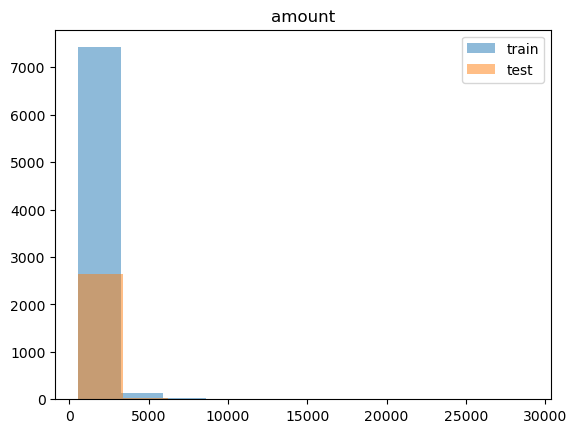

lat train 2804 test 940


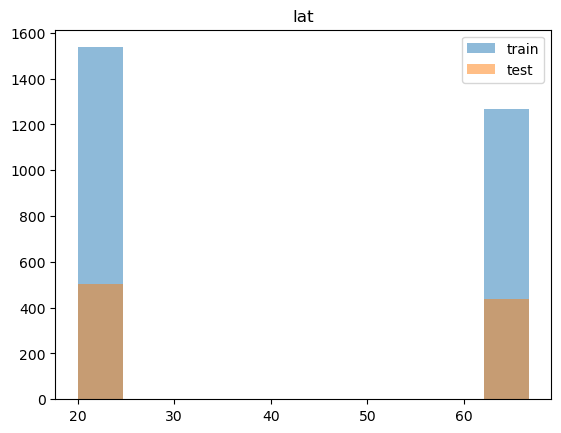

lon train 2804 test 940


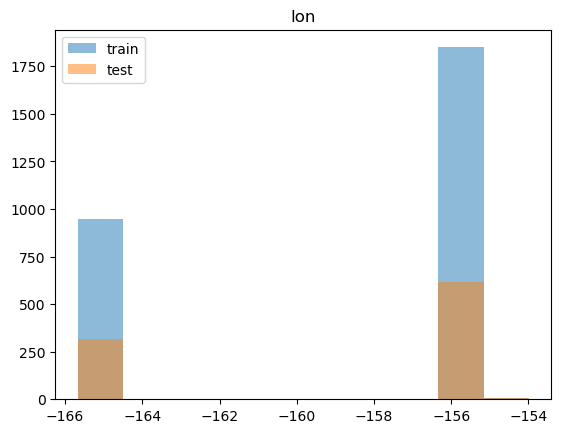

population_city train 20039 test 6572


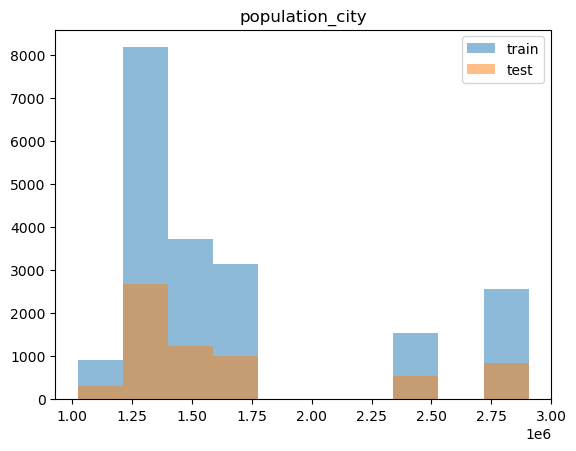

merchant_lat train 2804 test 940


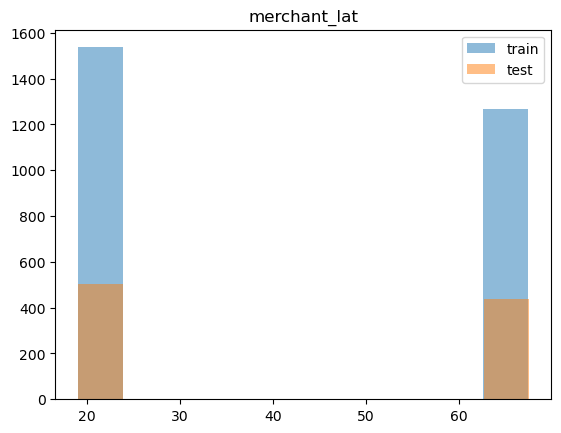

merchant_lon train 2804 test 940


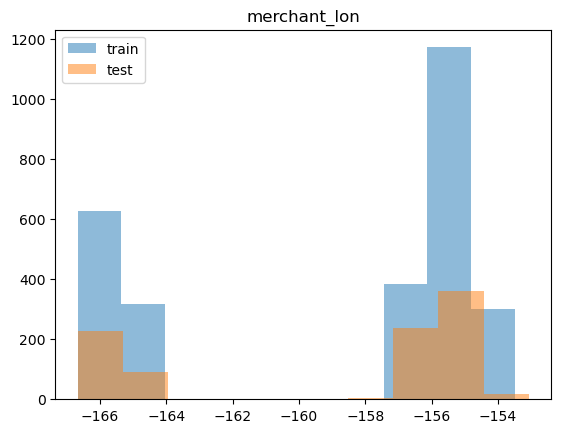

In [ ]:
for one_feature in numeric_features:

  mask_outliesr_train = np.abs(zscore(train[one_feature].values)) >= 3
  mask_outliesr_test = np.abs(zscore(test[one_feature].values)) >= 3

  print(
      one_feature,
      'train', sum(mask_outliesr_train),
      'test', sum(mask_outliesr_test),
  )

  plt.hist(train[mask_outliesr_train][one_feature], alpha=0.5, label='train')
  plt.hist(test[mask_outliesr_test][one_feature], alpha=0.5, label='test')
  plt.legend()
  plt.title(one_feature)
  plt.show()

Unique values in merch: 693


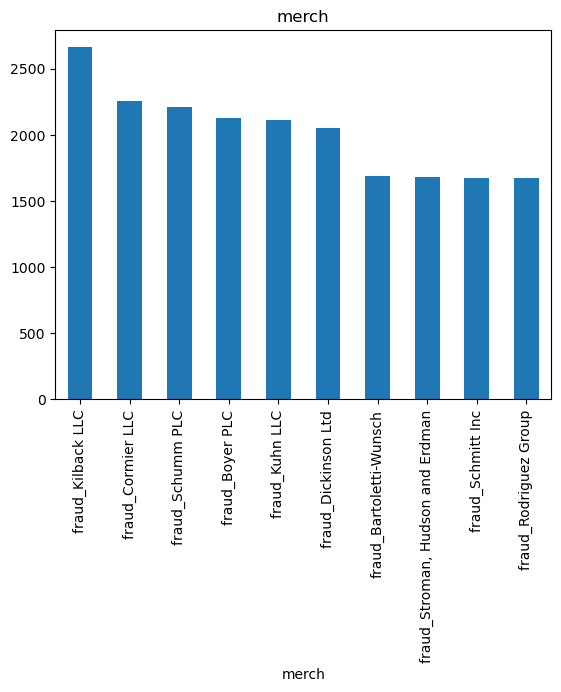

Unique values in cat_id: 14


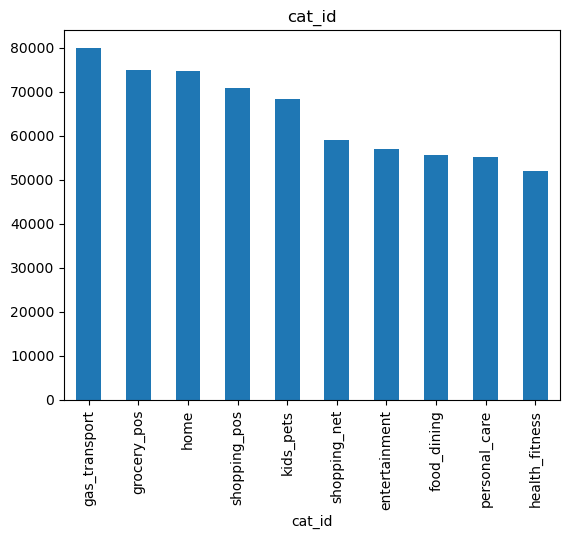

Unique values in gender: 2


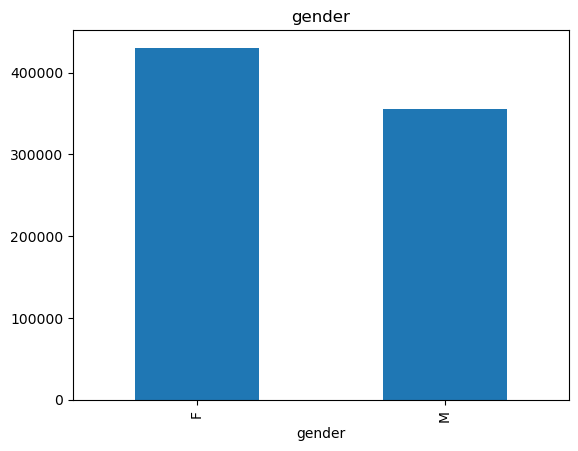

Unique values in name_1: 348


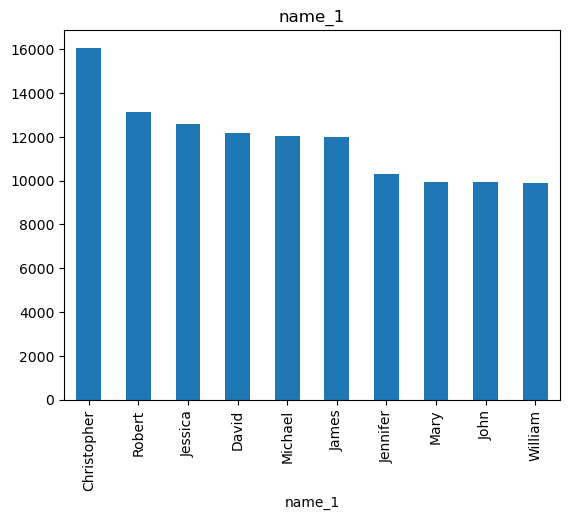

Unique values in name_2: 479


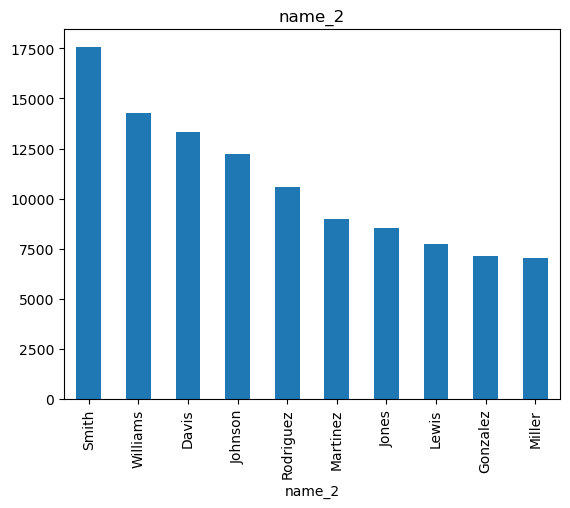

Unique values in gender: 2


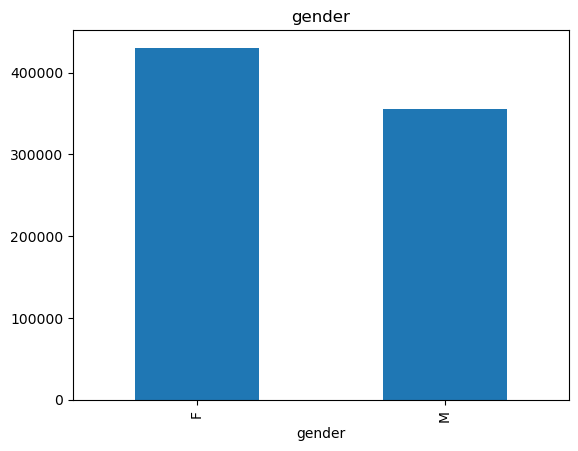

Unique values in street: 965


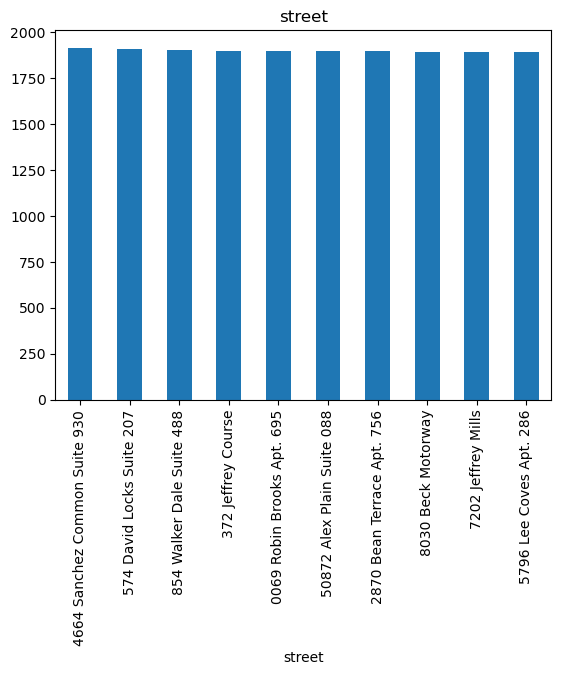

Unique values in one_city: 879


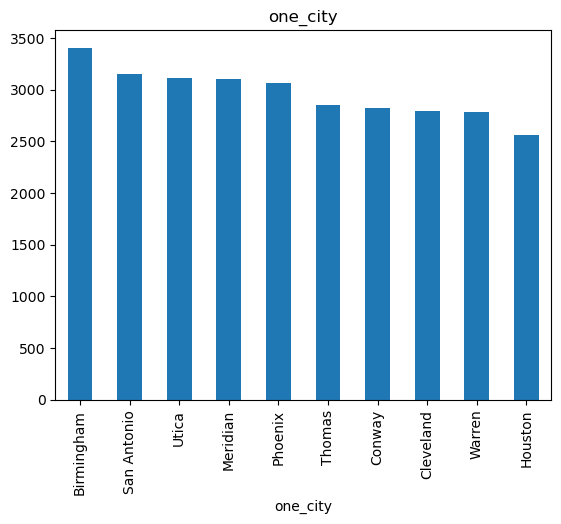

Unique values in us_state: 51


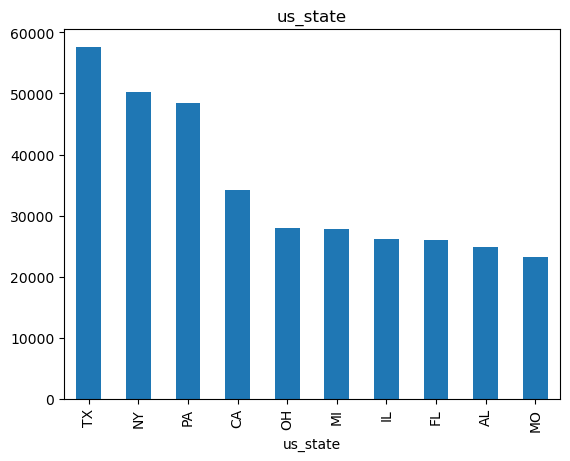

Unique values in post_code: 952


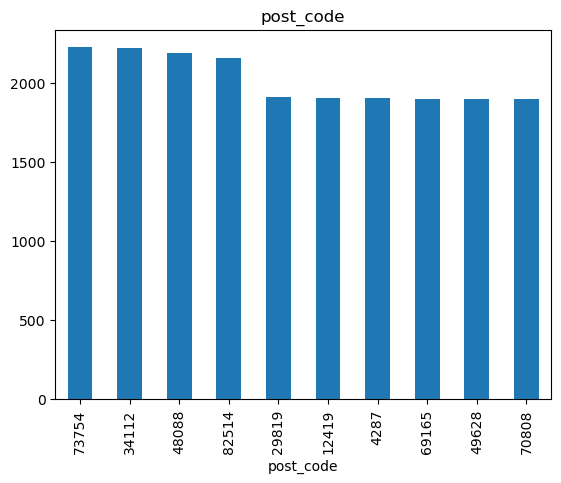

Unique values in jobs: 493


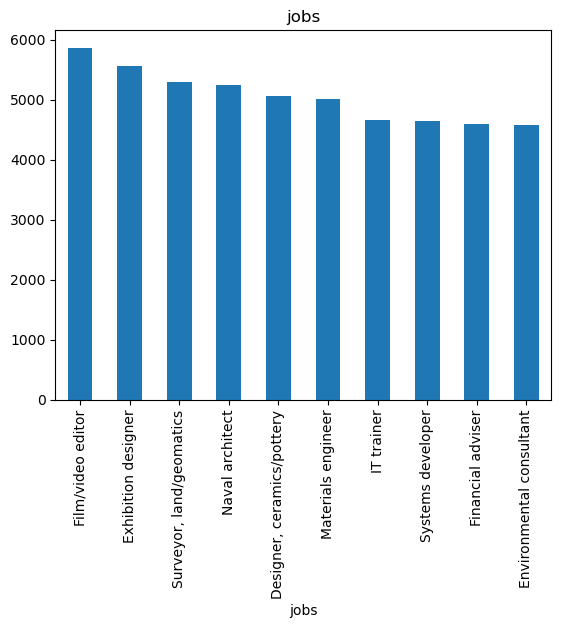

In [ ]:
for col in categorical_features:
    print(f"Unique values in {col}: {train[col].nunique()}")
    train[col].value_counts().head(10).plot(kind='bar', title=col)
    plt.show()

В целом сильных дисбалансов нет. Можем преобразовать категориальные данные.
Если мы будем преобразовывать эти категориальные фичи в One-Hot Encoding, то кажется получится слишком много фичей.

In [ ]:
c = 0
for one_feature in categorical_features:
  print(one_feature, train[one_feature].nunique())
  c += train[one_feature].nunique()
print(c)

merch 693
cat_id 14
gender 2
name_1 348
name_2 479
gender 2
street 965
one_city 879
us_state 51
post_code 952
jobs 493
4878


4878 - Это много, поэтому будем использовать Таргет кодер CatBoost Encoder

# 1.3. Инженерия признаков (Feature Engineering)

## 1.3.1. Обработка временного признака transaction_time

In [ ]:
# Извлечение часов, дней недели и месяцев
train['hour'] = train['transaction_time'].dt.hour
train['day_of_week'] = train['transaction_time'].dt.dayofweek  # 0 = понедельник, 6 = воскресенье
train['month'] = train['transaction_time'].dt.month

In [ ]:
# Извлечение часов, дней недели и месяцев для test
test['hour'] = test['transaction_time'].dt.hour
test['day_of_week'] = test['transaction_time'].dt.dayofweek  # 0 = понедельник, 6 = воскресенье
test['month'] = test['transaction_time'].dt.month

# Извлечение часов, дней недели и месяцев X_train
X_train['hour'] = X_train['transaction_time'].dt.hour
X_train['day_of_week'] = X_train['transaction_time'].dt.dayofweek  # 0 = понедельник, 6 = воскресенье
X_train['month'] = X_train['transaction_time'].dt.month

# Извлечение часов, дней недели и месяцев для X_test
X_test['hour'] = X_test['transaction_time'].dt.hour
X_test['day_of_week'] = X_test['transaction_time'].dt.dayofweek  # 0 = понедельник, 6 = воскресенье
X_test['month'] = X_test['transaction_time'].dt.month

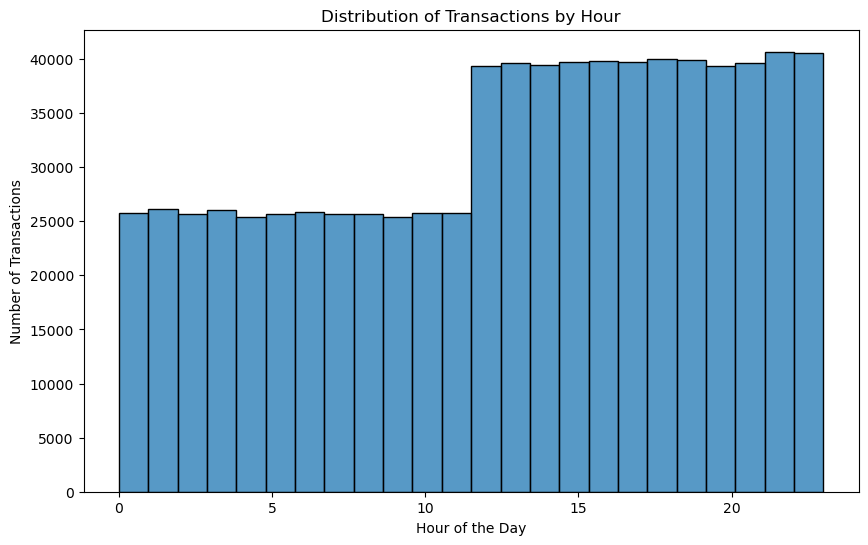

In [ ]:
# Распределение по часам
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(train['hour'], bins=24, kde=False)
plt.title('Distribution of Transactions by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Transactions')
plt.show()

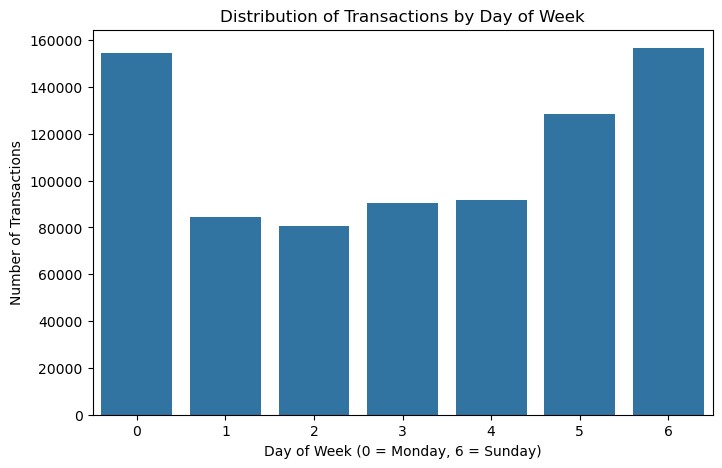

In [ ]:
#  Распределение по дням недели
plt.figure(figsize=(8, 5))
sns.countplot(x='day_of_week', data=train, order=range(7))
plt.title('Distribution of Transactions by Day of Week')
plt.xlabel('Day of Week (0 = Monday, 6 = Sunday)')
plt.ylabel('Number of Transactions')
plt.show()

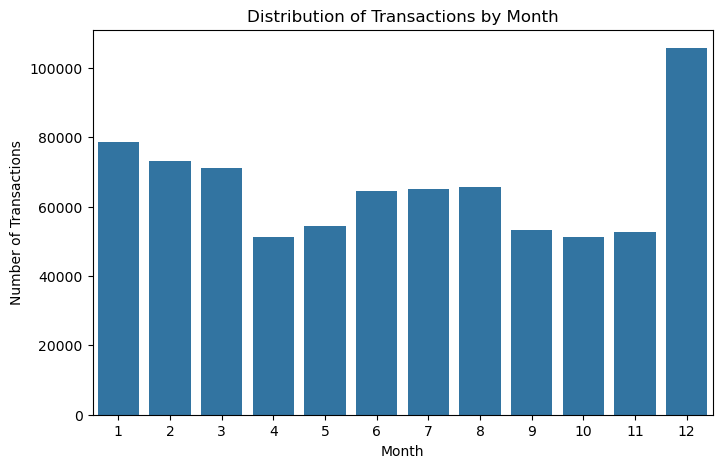

In [ ]:
#  Распределение по месяцам
plt.figure(figsize=(8, 5))
sns.countplot(x='month', data=train, order=range(1, 13))
plt.title('Distribution of Transactions by Month')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.show()

### 1.3.2 Анализ взаимосвязей  с фродом
исследуем взаимосвязи между временными компонентами и целевой переменной (target).

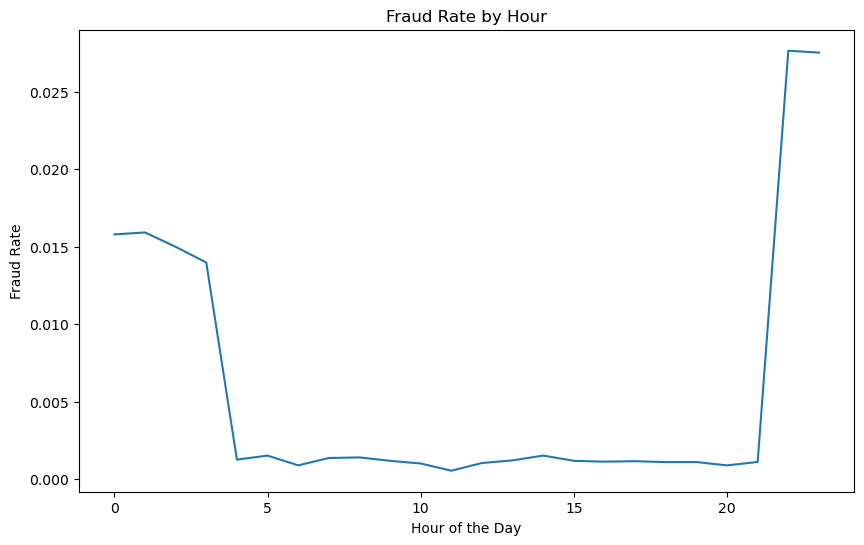

In [ ]:
# Среднее значение target по часам
hourly_fraud_rate = train.groupby('hour')['target'].mean()
plt.figure(figsize=(10, 6))
sns.lineplot(x=hourly_fraud_rate.index, y=hourly_fraud_rate.values)
plt.title('Fraud Rate by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Fraud Rate')
plt.show()

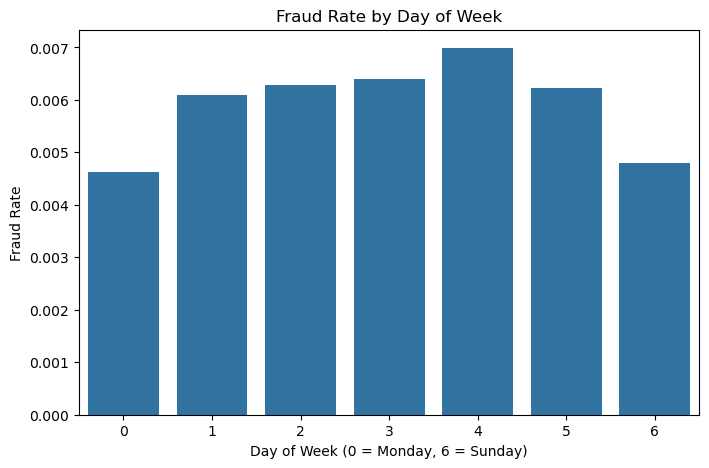

  Day of Week  Fraud Rate
0      Monday    0.004629
1     Tuesday    0.006090
2   Wednesday    0.006285
3    Thursday    0.006401
4      Friday    0.006987
5    Saturday    0.006233
6      Sunday    0.004788


In [ ]:
# Добавляем столбец с днем недели
train['day_of_week'] = pd.to_datetime(train['transaction_time']).dt.dayofweek

# Среднее значение target по дням недели
weekly_fraud_rate = train.groupby('day_of_week')['target'].mean()

# Визуализация
plt.figure(figsize=(8, 5))
sns.barplot(x=weekly_fraud_rate.index, y=weekly_fraud_rate.values)
plt.title('Fraud Rate by Day of Week')
plt.xlabel('Day of Week (0 = Monday, 6 = Sunday)')
plt.ylabel('Fraud Rate')
plt.show()

# Создание таблицы
weekly_fraud_table = pd.DataFrame({
    'Day of Week': ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    'Fraud Rate': weekly_fraud_rate.values
})

# Отображение таблицы
print(weekly_fraud_table)

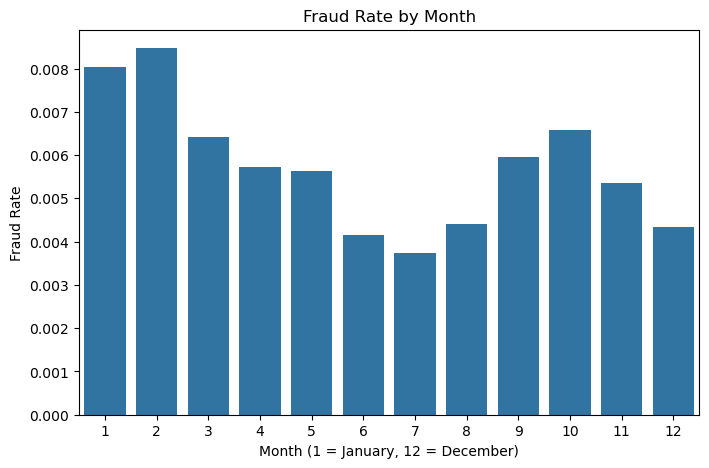

        Month  Fraud Rate
0     January    0.008048
1    February    0.008474
2       March    0.006430
3       April    0.005714
4         May    0.005631
5        June    0.004163
6        July    0.003740
7      August    0.004409
8   September    0.005966
9     October    0.006588
10   November    0.005347
11   December    0.004332


In [ ]:
# Среднее значение target по месяцам

# Добавляем столбец с месяцем
train['month'] = pd.to_datetime(train['transaction_time']).dt.month

# Среднее значение target по месяцам
monthly_fraud_rate = train.groupby('month')['target'].mean()

# Визуализация
plt.figure(figsize=(8, 5))
sns.barplot(x=monthly_fraud_rate.index, y=monthly_fraud_rate.values)
plt.title('Fraud Rate by Month')
plt.xlabel('Month (1 = January, 12 = December)')
plt.ylabel('Fraud Rate')
plt.show()

# Создание таблицы
monthly_fraud_table = pd.DataFrame({
    'Month': ['January', 'February', 'March', 'April', 'May', 'June',
              'July', 'August', 'September', 'October', 'November', 'December'],
    'Fraud Rate': monthly_fraud_rate.values
})

# Отображение таблицы
print(monthly_fraud_table)

Заметные патерны:

**Из распределения транзакций по часам/дням/месяцам:**
1. Наибольшее количество транзакций происходит в период с 12 по 23 час.
2. Наибольшее количество транзакций происходит в понедельник и воскресенье. Наименьшее количество транзакций — в среду.
3. Годовой пик продаж приходится на декабрь.

* в датасете test такие же распределения

**Из анализа взаимосвязи с фродом:**
1. Наибольшоая активность наблюдается в период с 21 по 4 часа утра.
- Возможно это повод создать новую переменную 'is_night'
2.  Вероятность мошенничества постепенно увеличивается к концу рабочей недели. Особенно высокая вероятность наблюдается в четверг и пятницу. Выходные дни (суббота и воскресенье):
Несмотря на большое количество транзакций (особенно в воскресенье), вероятность мошенничества ниже, чем в рабочие дни. (Можно создать бинарный флаг, который будет обозначать, является ли день рабочим)

В целом на основе этой информации можно сделать сразу три флага, но потом нужно будет проверить не будут ли он киллерировать:
- is_weekday: Бинарный флаг, который помогает модели отличить рабочие дни от выходных.
- is_end_of_week: Фокусируется на днях с повышенной вероятностью мошенничества (четверг и пятница).
- fraud_rate_by_day: Числовой признак, который точно отражает вероятность мошенничества для каждого дня. (Fraud Rate)


3. Сезонность транзакций
Зимние месяцы (декабрь, январь) характеризуются повышенной активностью транзакций и высокой вероятностью мошенничества.
Летние месяцы (июнь, июль) показывают минимальную вероятность мошенничества, несмотря на умеренное количество транзакций.
Весенний спад: апрель, май демонстрируют как низкое количество транзакций, так и относительно низкую вероятность мошенничества.
Осенью (сентябрь, октябрь) вероятность мошенничества начинает расти, хотя количество транзакций остается умеренным.
- Ставить флаг, как мне кажется, особого смысла нет. Можно создать числовой признак, который будет показывать относительную вероятность мошенничества для каждого месяца fraud_rate_by_month

In [ ]:
# Так как график распределения по часам показывает, что большинство мошеннических транзакций происходит ночью
# (с 21 до 4 часов), это может быть важным признаком:
train['is_night'] = ((train['hour'] >= 21) | (train['hour'] < 4)).astype(int)

# Для test, X_train, X_test
test['is_night'] = ((test['hour'] >= 21) | (test['hour'] < 4)).astype(int)
X_train['is_night'] = ((X_train['hour'] >= 21) | (X_train['hour'] < 4)).astype(int)
X_test['is_night'] = ((X_test['hour'] >= 21) | (X_test['hour'] < 4)).astype(int)


In [ ]:
# Флаг "рабочий день" (1-рабочий)
train['is_weekday'] = train['day_of_week'].isin([0, 1, 2, 3, 4]).astype(int)

# Для test, X_train, X_test
test['is_weekday'] = test['day_of_week'].isin([0, 1, 2, 3, 4]).astype(int)
X_train['is_weekday'] = X_train['day_of_week'].isin([0, 1, 2, 3, 4]).astype(int)
X_test['is_weekday'] = X_test['day_of_week'].isin([0, 1, 2, 3, 4]).astype(int)

In [ ]:
#  Флаг "конец недели" (1 означает четверг или пятницу.)
train['is_end_of_week'] = train['day_of_week'].isin([3, 4]).astype(int)

# Для test, X_train, X_test
test['is_end_of_week'] = test['day_of_week'].isin([3, 4]).astype(int)
X_train['is_end_of_week'] = X_train['day_of_week'].isin([3, 4]).astype(int)
X_test['is_end_of_week'] = X_test['day_of_week'].isin([3, 4]).astype(int)


In [ ]:
# Относительная вероятность мошенничества
fraud_rate_by_day = {
    0: 0.004629,  # Понедельник
    1: 0.006090,   # Вторник
    2: 0.006285,  # Среда
    3: 0.006401,  # Четверг
    4: 0.006987,   # Пятница
    5: 0.006233,   # Суббота
    6: 0.004788   # Воскресенье
}

train['fraud_rate_by_day'] = train['day_of_week'].map(fraud_rate_by_day)

# Для test, X_train, X_test
test['fraud_rate_by_day'] = test['day_of_week'].map(fraud_rate_by_day)
X_train['fraud_rate_by_day'] = X_train['day_of_week'].map(fraud_rate_by_day)
X_test['fraud_rate_by_day'] = X_test['day_of_week'].map(fraud_rate_by_day)

In [ ]:
fraud_rate_by_month = {
    1: 0.008048,   # Январь
    2: 0.008474,   # Февраль
    3: 0.006430,   # Март
    4: 0.005714,   # Апрель
    5: 0.005631,   # Май
    6: 0.004163,   # Июнь
    7: 0.003740,   # Июль
    8: 0.004409,   # Август
    9: 0.005966,   # Сентябрь
    10: 0.006588,  # Октябрь
    11: 0.005347,  # Ноябрь
    12: 0.004332   # Декабрь
}

train['fraud_rate_by_month'] = train['month'].map(fraud_rate_by_month)

# Для test, X_train, X_test
test['fraud_rate_by_month'] = test['month'].map(fraud_rate_by_month)
X_train['fraud_rate_by_month'] = X_train['month'].map(fraud_rate_by_month)
X_test['fraud_rate_by_month'] = X_test['month'].map(fraud_rate_by_month)

## 1.3.2 Географические признаки
    'lat', 'lon'
    'merchant_lat', 'merchant_lon'

In [ ]:
# Функция haversine_distance вычисляет расстояние между двумя точками на поверхности Земли,
# используя формулу гаверсинусов.

import numpy as np
from math import atan2, cos, radians, sin, sqrt

def haversine_distance(lat1: float, lon1: float, lat2: float, lon2: float, n_digits: int = 0) -> float:
    """
    Функция для расчёта расстояния от точки А до Б по прямой
    :param lat1: Широта точки А
    :param lon1: Долгота точки А
    :param lat2: Широта точки Б
    :param lon2: Долгота точки Б
    :param n_digits: Округляем полученный ответ до n знака после запятой
    :return: Дистанция по прямой с точностью до n_digits
    """
    # Округляем координаты для уменьшения погрешности
    lat1, lon1, lat2, lon2 = round(lat1, 6), round(lon1, 6), round(lat2, 6), round(lon2, 6)
    # Переводим широты и долготы в радианы
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    # Применяем формулу гаверсинусов
    a = np.sin(dphi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2) ** 2
    # Вычисляем расстояние в метрах
    return round(2 * 6372800 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)), n_digits)  # метры.сантиметры




def bearing_degree(lat1: float, lon1: float, lat2: float, lon2: float, n_digits: int = 0) -> float:
    """
        Функция для расчёта угла между прямой [((lat1, lon1), (lat2, lon2)), (нулевой мередиан)]

        :param lat1: Широта точки А
        :param lon1: Долгота точки А
        :param lat2: Широта точки Б
        :param lon2: Долгота точки Б
        :param n_digits: Округляем полученный ответ до n знака после запятой
        :return: Значение угла с точностью до n_digits
    """

    # Перевод координат в радианы
    lat1, lon1 = np.radians(round(lat1, 6)), np.radians(round(lon1, 6))
    lat2, lon2 = np.radians(round(lat2, 6)), np.radians(round(lon2, 6))

    # Вычисление разницы долгот : Эти формулы основаны на математике сферической тригонометрии
    # и позволяют вычислить направление между двумя точками.
    dlon = (lon2 - lon1)

    # Вычисление числителя и знаменателя
    numerator = np.sin(dlon) * np.cos(lat2)
    denominator = np.cos(lat1) * np.sin(lat2) - (np.sin(lat1) * np.cos(lat2) * np.cos(dlon))

    # Вычисление угла через арктангенс и  перевод в градусы
    theta = np.arctan2(numerator, denominator)
    theta_deg = (np.degrees(theta) + 360) % 360

    return round(theta_deg, n_digits)

(array([91261., 79812., 49595., 79878., 91075., 90796., 81262., 49594.,
        78581., 94577.]),
 array([  0.,  36.,  72., 108., 144., 180., 216., 252., 288., 324., 360.]),
 <BarContainer object of 10 artists>)

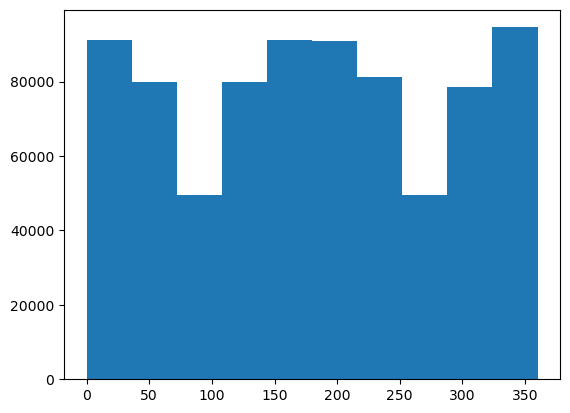

In [ ]:
plt.hist(bearing_degree(train['lat'], train['lon'], train['merchant_lat'], train['merchant_lon'],).values)

У вас есть следующие географические координаты:
- Координаты клиента (lat, lon): место жительства клиента.
- Координаты продавца (merchant_lat, merchant_lon): место совершения транзакции.

Мы будем использовать эти координаты для вычисления:

1. Расстояния между клиентом и продавцом — это может быть полезным индикатором аномалий.
2. Угла между клиентом и продавцом — дополнительный контекст направления движения.

### 3.2.1 Вычисление расстояния
Используем функцию haversine_distance, чтобы вычислить расстояние между клиентом и продавцом:

In [ ]:
# Добавляем новую фичу: расстояние между клиентом и продавцом
train['hav_dist_1'] = haversine_distance(train['lat'], train['lon'], train['merchant_lat'], train['merchant_lon'], ).values

# Посчитаем угол между клиентом и продавцом:
train['bearing_degree_1'] = bearing_degree(train['lat'], train['lon'], train['merchant_lat'], train['merchant_lon'], ).values

In [ ]:
# Для test, X_train, X_test расстояние и угол между клиентом и продавцом
test['hav_dist_1'] = haversine_distance(test['lat'], test['lon'], test['merchant_lat'], test['merchant_lon'], ).values
X_train['hav_dist_1'] = haversine_distance(X_train['lat'], X_train['lon'], X_train['merchant_lat'], X_train['merchant_lon'], ).values
X_test['hav_dist_1'] = haversine_distance(X_test['lat'], X_test['lon'], X_test['merchant_lat'], X_test['merchant_lon'], ).values


test['bearing_degree_1'] = bearing_degree(test['lat'], test['lon'], test['merchant_lat'], test['merchant_lon'], ).values
X_train['bearing_degree_1'] = bearing_degree(X_train['lat'], X_train['lon'], X_train['merchant_lat'], X_train['merchant_lon'], ).values
X_test['bearing_degree_1'] = bearing_degree(X_test['lat'], X_test['lon'], X_test['merchant_lat'], X_test['merchant_lon'], ).values

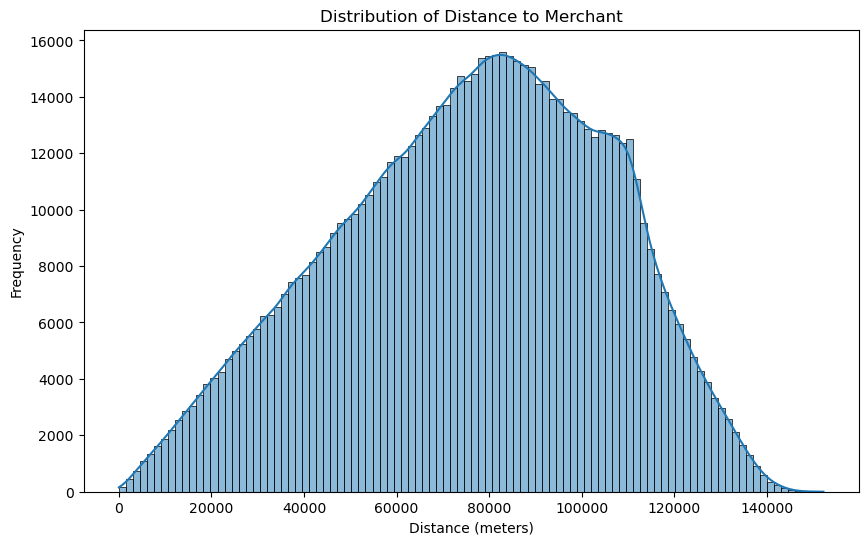

Descriptive Statistics for Distance to Merchant:
  Statistic          Value
0     Count  786431.000000
1      Mean   76099.714292
2       Std   29112.476951
3       Min      22.000000
4       25%   55334.000000
5       50%   78208.000000
6       75%   98462.000000
7       Max  152160.000000


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Визуализация распределения расстояний
plt.figure(figsize=(10, 6))
sns.histplot(train['hav_dist_1'], bins=100, kde=True)
plt.title('Distribution of Distance to Merchant')
plt.xlabel('Distance (meters)')
plt.ylabel('Frequency')
plt.show()

# Описательная статистика для расстояний
distance_stats = train['hav_dist_1'].describe()

# Создание таблицы с описательной статистикой
distance_stats_table = pd.DataFrame({
    'Statistic': ['Count', 'Mean', 'Std', 'Min', '25%', '50%', '75%', 'Max'],
    'Value': [
        distance_stats['count'],
        distance_stats['mean'],
        distance_stats['std'],
        distance_stats['min'],
        distance_stats['25%'],
        distance_stats['50%'],
        distance_stats['75%'],
        distance_stats['max']
    ]
})

# Отображение таблицы
print("Descriptive Statistics for Distance to Merchant:")
print(distance_stats_table)

Большинство покупателей проживают в пределах 80 км от места транзакции.

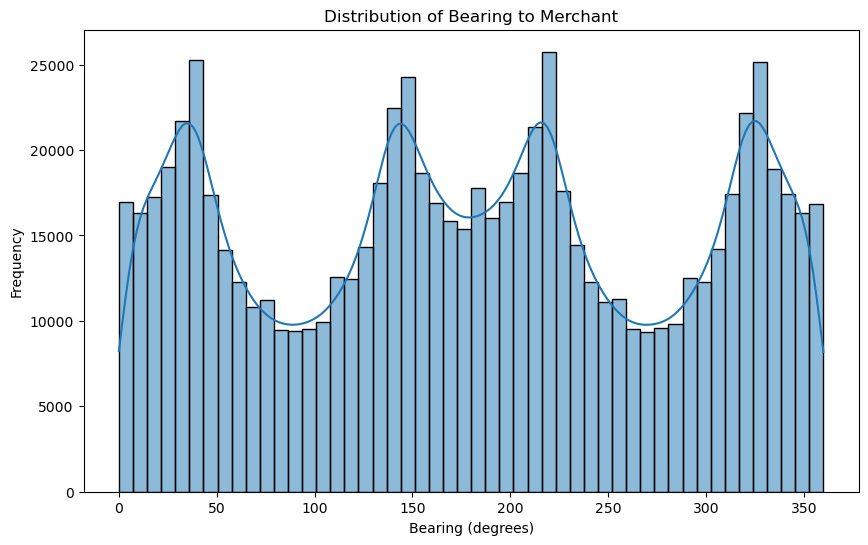

In [ ]:
# Посмотрим на распределение углов:
plt.figure(figsize=(10, 6))
sns.histplot(train['bearing_degree_1'], bins=50, kde=True)
plt.title('Distribution of Bearing to Merchant')
plt.xlabel('Bearing (degrees)')
plt.ylabel('Frequency')
plt.show()

Многовершинный : Несколько пиков, соответствующих обычным направлениям.

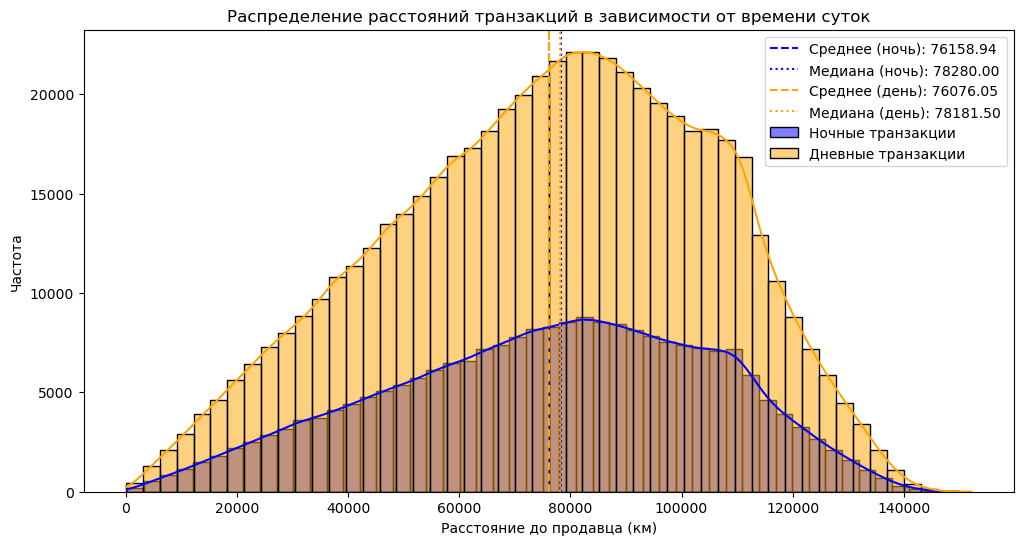

In [ ]:
# Сравним растояния транзакций в дневное и ночное время (когда фрода больше)
# Фильтрация данных по времени суток
night_transactions = train[train['is_night'] == 1]
day_transactions = train[train['is_night'] == 0]

# Расчет средних и медиан
night_mean = night_transactions['hav_dist_1'].mean()
night_median = night_transactions['hav_dist_1'].median()

day_mean = day_transactions['hav_dist_1'].mean()
day_median = day_transactions['hav_dist_1'].median()

# Построение распределений расстояний
plt.figure(figsize=(12, 6))

# Распределение расстояний для ночных транзакций
sns.histplot(
    night_transactions['hav_dist_1'],
    bins=50,
    color='blue',
    label='Ночные транзакции',
    kde=True
)

# Распределение расстояний для дневных транзакций
sns.histplot(
    day_transactions['hav_dist_1'],
    bins=50,
    color='orange',
    label='Дневные транзакции',
    kde=True
)

# Добавление вертикальных линий для средних и медиан
plt.axvline(night_mean, color='blue', linestyle='--', label=f'Среднее (ночь): {night_mean:.2f}')
plt.axvline(night_median, color='blue', linestyle=':', label=f'Медиана (ночь): {night_median:.2f}')

plt.axvline(day_mean, color='orange', linestyle='--', label=f'Среднее (день): {day_mean:.2f}')
plt.axvline(day_median, color='orange', linestyle=':', label=f'Медиана (день): {day_median:.2f}')

plt.title('Распределение расстояний транзакций в зависимости от времени суток')
plt.xlabel('Расстояние до продавца (км)')
plt.ylabel('Частота')
plt.legend()
plt.show()

Как и ожидалось, частота ночных транзакций ниже, чем дневных. Однако и расстояние от места покупки до дома покупателя для дневных и ночных покупок примерно одинаковое.

/var/folders/_z/cmfnjywj405_qrhzd3g2fzgw0000gp/T/ipykernel_14649/1263624296.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


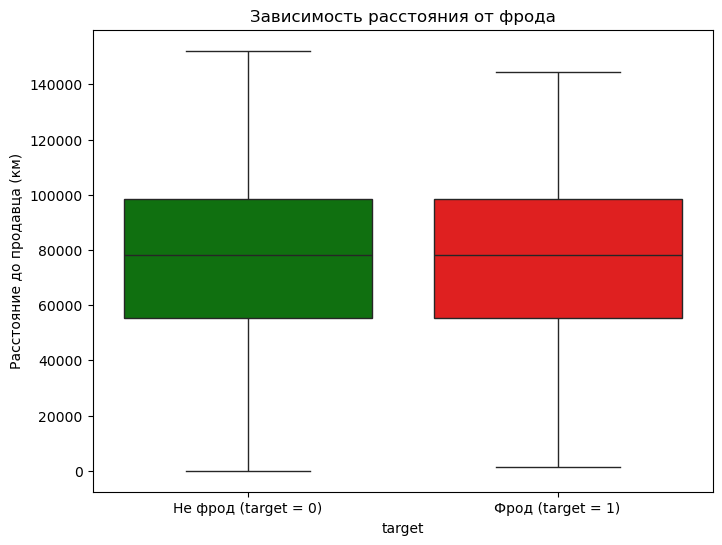

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(
    x='target',
    y='hav_dist_1',
    data=train,
    palette=['green', 'red']
)
plt.xticks(ticks=[0, 1], labels=['Не фрод (target = 0)', 'Фрод (target = 1)'])
plt.title('Зависимость расстояния от фрода')
plt.ylabel('Расстояние до продавца (км)')
plt.show()

/Users/annashestakova/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


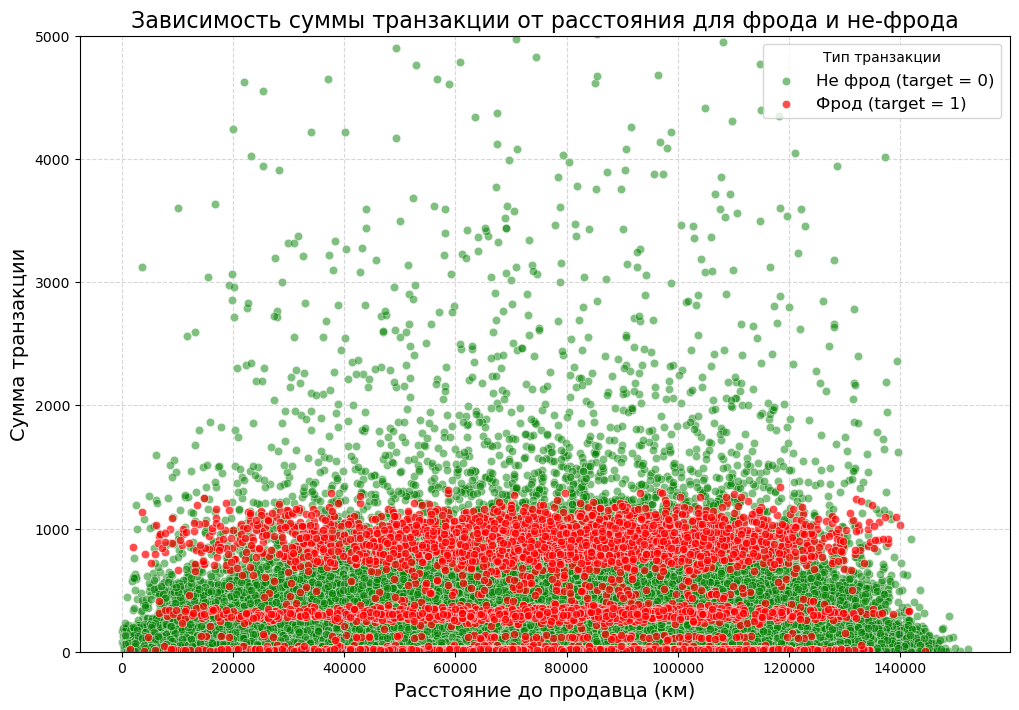

In [ ]:
# Разделение данных на фрод и не-фрод
fraud_transactions = train[train['target'] == 1]
non_fraud_transactions = train[train['target'] == 0]

# Построение scatter plot
plt.figure(figsize=(12, 8))

# Точки для не-фрода (зеленые)
sns.scatterplot(
    x='hav_dist_1',
    y='amount',
    data=non_fraud_transactions,
    color='green',
    label='Не фрод (target = 0)',
    alpha=0.5
)

# Точки для фрода (красные)
sns.scatterplot(
    x='hav_dist_1',
    y='amount',
    data=fraud_transactions,
    color='red',
    label='Фрод (target = 1)',
    alpha=0.7
)

# Добавление заголовка и подписей осей
plt.title('Зависимость суммы транзакции от расстояния для фрода и не-фрода', fontsize=16)
plt.xlabel('Расстояние до продавца (км)', fontsize=14)
plt.ylabel('Сумма транзакции', fontsize=14)

# Добавление легенды
plt.legend(title='Тип транзакции', fontsize=12)


# # Ограничение по оси y
plt.ylim(0, 5000)

# Отображение графика
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Можно заметить, что фрод встречается на всех вариантах расстояниях между местом жительства покупателя и местом проведения транзакции. При этом мошеннические транзакции, как правило, не превышают 1200$.

### 3.2.2 Дополнительные исследования по координатам и штатам

#### 5.2 Группировка по штатам
Если у вас есть информация о штатах (`us_state`), можно проанализировать статистику по каждому штату:
- Среднее расстояние до продавца.
- Частота мошеннических транзакций.

In [ ]:
state_stats = train.groupby('us_state').agg({
    'hav_dist_1': 'mean',
    'target': 'mean'
}).reset_index()

print(state_stats.sort_values(by='target', ascending=False))

   us_state    hav_dist_1    target
8        DE  83454.666667  1.000000
39       RI  78672.948795  0.030120
0        AK  62709.782952  0.014996
29       NE  75080.551615  0.008107
42       TN  77328.815614  0.008070
33       NV  75454.562684  0.007946
9        FL  80310.552121  0.007641
5        CO  75671.254970  0.007545
37       OR  73167.498095  0.007531
21       ME  73680.439203  0.007432
30       NH  74051.624900  0.007430
35       OH  75600.220486  0.007169
34       NY  74342.716047  0.007080
7        DC  76680.045516  0.006760
23       MN  72863.890076  0.006536
14       IL  75410.058729  0.006309
40       SC  78323.041735  0.006043
24       MO  76261.100021  0.006007
45       VA  76798.801244  0.005996
50       WY  74367.474896  0.005947
4        CA  76788.192922  0.005937
17       KY  76451.651582  0.005830
12       IA  74558.130394  0.005696
2        AR  77434.599315  0.005565
1        AL  78764.529716  0.005534
22       MI  73694.673930  0.005493
49       WV  76063.745605  0

Выше вывели таблицу, отсортированную по доле мошеннических транзакций (target) в порядке убывания. Таблица содержит информацию о штатах, среднем расстоянии до продавца и средней доле мошеннических транзакциях:

- В штатах DE и RI доля мошеннических транзакций очень высока (близка к 100%).
- В штатах CT и ID доля мошеннических транзакций крайне низкая.


Построим тепловую карту США, чтобы визуализировать распределение мошеннических транзакций по штатам.


In [ ]:
# Группируем данные по штатам и вычисляем среднюю долю мошеннических транзакций
state_fraud_rate = train.groupby('us_state')['target'].mean().reset_index()

print(state_fraud_rate.head())

  us_state    target
0       AK  0.014996
1       AL  0.005534
2       AR  0.005565
3       AZ  0.003073
4       CA  0.005937


In [4]:
# import plotly.express as px

# # Создаем карту
# fig = px.choropleth(
#     state_stats,                             # Данные
#     locations='us_state',                      # Столбец с кодами штатов
#     locationmode='USA-states',                 # Указываем, что данные — это штаты США
#     color='target',                           # Значения для цветовой шкалы
#     color_continuous_scale='Reds',             # Цветовая палитра (красная для фродов)
#     scope='usa',                               # Ограничение карты на территорию США
#     title='Fraud Rate by State'                # Заголовок карты
# )

# # Отображаем карту
# fig.show()

In [5]:
# import plotly.express as px

# # Создаем scatter_mapbox для отображения точек на карте
# fig = px.scatter_mapbox(
#     train,                                  # Данные
#     lat='lat',                              # Широта
#     lon='lon',                              # Долгота
#     color='target',                         # Цветовая дифференциация по target
#     color_continuous_scale=['green', 'red'], # Зеленый для не-фрода, красный для фрода
#     title='Распределение транзакций по координатам (Фрод/Не фрод)', # Заголовок
#     zoom=3,                                 # Уровень масштабирования
#     height=600                              # Высота графика
# )

# # Настройка стиля карты
# fig.update_layout(mapbox_style="open-street-map")  # Используем стиль OpenStreetMap
# fig.update_layout(margin={"r": 0, "t": 30, "l": 0, "b": 0})  # Убираем отступы

# # Отображаем карту
# fig.show()

In [6]:
# import plotly.express as px

# # Создаем scatter_mapbox для отображения точек на карте
# fig = px.scatter_mapbox(
#     train,                                  # Данные
#     lat='merchant_lat',                              # Широта
#     lon='merchant_lon',                              # Долгота
#     color='target',                         # Цветовая дифференциация по target
#     color_continuous_scale=['green', 'red'], # Зеленый для не-фрода, красный для фрода
#     title='Распределение транзакций по координатам (Фрод/Не фрод)', # Заголовок
#     zoom=3,                                 # Уровень масштабирования
#     height=600                              # Высота графика
# )

# # Настройка стиля карты
# fig.update_layout(mapbox_style="open-street-map")  # Используем стиль OpenStreetMap
# fig.update_layout(margin={"r": 0, "t": 30, "l": 0, "b": 0})  # Убираем отступы

# # Отображаем карту
# fig.show()

Итак на основе анализа георафических данных сохдадим следующие признаки:
- создадим признак вероятности фрода по штатам (fraud_rate)
- выполним кластеризацию, используя как координаты (lat, lon), так и вероятность фрода (fraud_rate)

 #### признак вероятности фрода по штатам (fraud_rate_State)

In [ ]:
# Создаем признак средняя частота фрода по штатам
# Вычисляем вероятность фрода для train и test
state_fraud_rate = train.groupby('us_state')['target'].mean()
train['fraud_rate_State'] = train['us_state'].map(state_fraud_rate)
test['fraud_rate_State'] = test['us_state'].map(state_fraud_rate)

# Заполняем пропуски средним значением (если есть штаты без данных)
train['fraud_rate_State'] = train['fraud_rate_State'].fillna(train['fraud_rate_State'].mean())
test['fraud_rate_State'] = test['fraud_rate_State'].fillna(test['fraud_rate_State'].mean())

# Вычисляем вероятность фрода для X_train и X_test
state_fraud_rate = X_train_with_target.groupby('us_state')['target'].mean()
X_train['fraud_rate_State'] = X_train['us_state'].map(state_fraud_rate)
X_test['fraud_rate_State'] = X_test['us_state'].map(state_fraud_rate)

# Заполняем пропуски средним значением (если есть штаты без данных)
X_train['fraud_rate_State'] = X_train['fraud_rate_State'].fillna(X_train['fraud_rate_State'].mean())
X_test['fraud_rate_State'] = X_test['fraud_rate_State'].fillna(X_test['fraud_rate_State'].mean())

#### выполним кластеризацию, используя как координаты  покупателя(lat, lon), так и вероятность фрода fraud_rate_latlon

Теперь у нас есть новый признак fraud_rate, который отражает вероятность фрода для каждого штата.


Попробуем так же создать **кластеры с вероятностью фрода**
- по каординатам покупателя.
- по каординатам продавца.

Для этоо обучим KMeans на комбинации координат и target, а затем применим модель к тестовым данным, где target отсутствует.

In [ ]:
# Для покупателей
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 1. Вычисление вероятности фрода
# Вычисляем вероятность фрода для train и test
train['fraud_rate_latlon'] = train.groupby(['lat', 'lon'])['target'].transform('mean')
fraud_rate_dict = train.groupby(['lat', 'lon'])['fraud_rate_latlon'].mean().to_dict()
test['fraud_rate_latlon'] = test.set_index(['lat', 'lon']).index.map(fraud_rate_dict).fillna(train['fraud_rate_latlon'].mean())

# Вычисляем вероятность фрода для X_train и X_test
X_train_with_target['fraud_rate_latlon'] = X_train_with_target.groupby(['lat', 'lon'])['target'].transform('mean')
fraud_rate_dict = X_train_with_target.groupby(['lat', 'lon'])['fraud_rate_latlon'].mean().to_dict()

# Добавляем fraud_rate_latlon в X_train и X_test
X_train['fraud_rate_latlon'] = X_train.set_index(['lat', 'lon']).index.map(fraud_rate_dict).fillna(X_train_with_target['fraud_rate_latlon'].mean())
X_test['fraud_rate_latlon'] = X_test.set_index(['lat', 'lon']).index.map(fraud_rate_dict).fillna(X_train_with_target['fraud_rate_latlon'].mean())


# 2: Нормализация данных
# Перед кластеризацией нормализуtv признаки (lat, lon, fraud_rate),
# чтобы они имели одинаковый масштаб.
# Это важно, так как fraud_rate имеет другой диапазон значений по сравнению с координатами.
train_cluster = train[['lat', 'lon', 'fraud_rate_latlon']]
X_train_cluster = X_train[['lat', 'lon', 'fraud_rate_latlon']]
X_test_cluster = X_test[['lat', 'lon', 'fraud_rate_latlon']]
test_cluster = test[['lat', 'lon', 'fraud_rate_latlon']]

scaler = StandardScaler()
train_cluster_scaled = scaler.fit_transform(train_cluster)
X_train_cluster_scaled = scaler.fit_transform(X_train_cluster)
X_test_cluster_scaled = scaler.transform(X_test_cluster)
test_cluster_scaled = scaler.transform(test_cluster)


# 3. Кластеризация
kmeans = KMeans(n_clusters=10, random_state=42)
train['cluster_fraud_rate'] = kmeans.fit_predict(train_cluster_scaled)
test['cluster_fraud_rate'] = kmeans.predict(test_cluster_scaled)

X_train['cluster_fraud_rate'] = kmeans.fit_predict(X_train_cluster_scaled)
X_test['cluster_fraud_rate'] = kmeans.predict(X_test_cluster_scaled)

## 1.3.3 Агрегированные признаки
Создайте агрегированные признаки для категориальных переменных:

In [ ]:
# Средняя сумма транзакций по каждому продавцу
# Для  train и test
merchant_avg_amount = train.groupby('merch')['amount'].mean()
train['merchant_avg_amount'] = train['merch'].map(merchant_avg_amount)

merchant_avg_amount = test.groupby('merch')['amount'].mean()
test['merchant_avg_amount'] = test['merch'].map(merchant_avg_amount)

# Для  X_train, X_test
merchant_avg_amount = X_train.groupby('merch')['amount'].mean()
X_train['merchant_avg_amount'] = X_train['merch'].map(merchant_avg_amount)

merchant_avg_amount = X_test.groupby('merch')['amount'].mean()
X_test['merchant_avg_amount'] = X_test['merch'].map(merchant_avg_amount)


In [ ]:
# Частота транзакций по каждому продавцу
# Для  train и test
merchant_transaction_count = train['merch'].value_counts()
train['merchant_transaction_count'] = train['merch'].map(merchant_transaction_count)

merchant_transaction_count = test['merch'].value_counts()
test['merchant_transaction_count'] = test['merch'].map(merchant_transaction_count)

# Для X_train, X_test

merchant_transaction_count = X_train['merch'].value_counts()
X_train['merchant_transaction_count'] = X_train['merch'].map(merchant_transaction_count)

merchant_transaction_count = X_test['merch'].value_counts()
X_test['merchant_transaction_count'] = X_test['merch'].map(merchant_transaction_count)

# 1.4 Стартовые фичи для модели

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 526908 entries, 736116 to 49642
Data columns (total 34 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   transaction_time            526908 non-null  datetime64[ns]
 1   merch                       526908 non-null  object        
 2   cat_id                      526908 non-null  object        
 3   amount                      526908 non-null  float64       
 4   name_1                      526908 non-null  object        
 5   name_2                      526908 non-null  object        
 6   gender                      526908 non-null  object        
 7   street                      526908 non-null  object        
 8   one_city                    526908 non-null  object        
 9   us_state                    526908 non-null  object        
 10  post_code                   526908 non-null  int64         
 11  lat                         526908 non-n

In [ ]:
# Преобразуем transaction_time в число
train['ts_transaction_time'] = pd.to_datetime(train['transaction_time']).values.astype('int64') // 10**9
test['ts_transaction_time'] = pd.to_datetime(test['transaction_time']).values.astype('int64') // 10**9
X_train['ts_transaction_time'] = pd.to_datetime(X_train['transaction_time']).values.astype('int64') // 10**9
X_test['ts_transaction_time'] = pd.to_datetime(X_test['transaction_time']).values.astype('int64') // 10**9

In [ ]:
# Удаляем исходную колонку transaction_time
train = train.drop('transaction_time', axis=1)
test = test.drop('transaction_time', axis=1)
X_train = X_train.drop('transaction_time', axis=1)
X_test = X_test.drop('transaction_time', axis=1)

In [ ]:
# Проверка на пропуски:
train.isnull().sum().sum() + train.isna().sum().sum()

0

In [ ]:
# Проверка на пропуски:
X_train.isnull().sum().sum() + train.isna().sum().sum()

0

In [ ]:
# Сформируем обновленный список категориальных переменных для кодирования для модели
# cat_columns = train.dtypes[train.dtypes == 'object'].index.tolist()
# num_columns = train.select_dtypes(include=['int64', 'float64']).columns.tolist()

cat_columns = ['merch',
 'cat_id',
 'name_1',
 'name_2',
 'gender',
 'street',
 'one_city',
 'us_state',
 'jobs',
 'post_code' # это скорее категория
              ]

num_columns = ['amount',
 'lat',
 'lon',
 'population_city',
 'merchant_lat',
 'merchant_lon',
 'log_amount',
 'log_population_city',
 'is_night',
 'is_weekday',
 'is_end_of_week',
 'fraud_rate_by_day',
 'fraud_rate_by_month',
 'hav_dist_1',
 'bearing_degree_1',
 'fraud_rate_State',
 'fraud_rate_latlon',
 'merchant_avg_amount',
 'merchant_transaction_count',
 'ts_transaction_time']

## 1.4.1 Проводим Category Encoders

In [ ]:
import category_encoders as ce

# Создаем энкодер для train и test
target_enc = ce.CatBoostEncoder(cols=cat_columns)

# Обучаем энкодер на тренировочных данных
target_enc.fit(train[cat_columns], train['target'])

# Преобразуем тренировочные и тестовые данные
train = train.join(target_enc.transform(train[cat_columns]).add_suffix('_cb'))
test = test.join(target_enc.transform(test[cat_columns]).add_suffix('_cb'))


# Создаем энкодер для X_train и X_test
target_enc = ce.CatBoostEncoder(cols=cat_columns)

# Обучаем энкодер на тренировочных данных
target_enc.fit(X_train[cat_columns], y_train)

# Преобразуем тренировочные и тестовые данные
X_train = X_train.join(target_enc.transform(X_train[cat_columns]).add_suffix('_cb'))
X_test = X_test.join(target_enc.transform(X_test[cat_columns]).add_suffix('_cb'))

In [ ]:
start_columns = num_columns + [col + '_cb' for col in cat_columns]
start_columns

['amount',
 'lat',
 'lon',
 'population_city',
 'merchant_lat',
 'merchant_lon',
 'log_amount',
 'log_population_city',
 'is_night',
 'is_weekday',
 'is_end_of_week',
 'fraud_rate_by_day',
 'fraud_rate_by_month',
 'hav_dist_1',
 'bearing_degree_1',
 'fraud_rate_State',
 'fraud_rate_latlon',
 'merchant_avg_amount',
 'merchant_transaction_count',
 'ts_transaction_time',
 'merch_cb',
 'cat_id_cb',
 'name_1_cb',
 'name_2_cb',
 'gender_cb',
 'street_cb',
 'one_city_cb',
 'us_state_cb',
 'jobs_cb',
 'post_code_cb']

In [ ]:
len(start_columns)

30

In [ ]:
train.isna().sum().sum() + test.isna().sum().sum() + X_train.isna().sum().sum() + X_test.isna().sum().sum()

0

# 2. Обучение модели на X_train

## 2.1 Работа с дисбалансом таргета.

In [ ]:
# В самом начале мы установили наличие дисбаланса классов в таргете,
# И так как мы разделили выборку с сохранением исходного баланса
# Сильный дисбаланс так же присутствует и у y_train
print(y_train.value_counts(normalize=True))


target
0    0.994272
1    0.005728
Name: proportion, dtype: float64


Сейчас бдем параметры  LGBMClassifier, которые позволяют модели учитывать дисбаланс классов.

В LGBMClassifier есть два параметра, которые можно настроить для учета дисбаланса: scale_pos_weight и class_weight='balanced'. Эти настройки позволяют скорректировать веса классов, чтобы модель уделяла больше внимания меньшему классу.

И так как нам нужно буде подобрать оптимальный трешхолд,  будем использовать  параметр scale_pos_weight=scale_pos_weight.

(Дале с ансамблями будет уже SMOTE)

In [ ]:
# Расчет scale_pos_weight
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

## 2.2 Base model . LGBMClassifier

In [ ]:
# Еще раз зафиксируем переменные на которых обучем и проверяем модель
# X_train, y_train, X_test, y_test
# колонки start_columns

Первая модель.

Зададим порог для бинаризации по умолчанию равеным 0.5.
Это означает, что если вероятность принадлежности к классу "1" больше или равна 0.5, объект классифицируется как "1", иначе как "0".

In [3]:
# первая модель

# Расчет scale_pos_weight
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Обучение модели
model = LGBMClassifier(
    random_state=42,
    objective='binary',
    metric='f1',
    max_depth=6,
    num_leaves=31,
    scale_pos_weight=scale_pos_weight
)
model.fit(X_train[start_columns], y_train)

# Предсказания
y_pred = model.predict(X_test[start_columns])

# Оценка качества
print("F1 Score:", f1_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    258037
           1       0.07      0.63      0.13      1486

    accuracy                           0.95    259523
   macro avg       0.53      0.79      0.55    259523
weighted avg       0.99      0.95      0.97    259523


Анализ результатов
- Класс "0": Модель идеально справляется с предсказанием класса "0". Это связано с тем, что он сильно доминирует в данных.
- Класс "1": Precision (0.53) ниже, чем хотелось бы. Это означает, что модель часто ошибочно относит объекты к классу "1".
- Recall (0.78) выше, чем Precision, что говорит о том, что модель находит большинство объектов класса "1", но допускает много ложных срабатываний.
- Общий вывод: Модель хорошо работает с доминирующим классом ("0"), но качество предсказания для меньшего класса ("1") требует улучшения.
F1-score для класса "1" (0.63) указывает на умеренное качество


Попробуем настроить threshold.
По умолчанию LightGBM использует порог вероятности 0.5 для классификации. Попробуем его изменить.

### 2.2.1  Расчет оптимального threshold.

Теперь вычислим оптимальный порог, который максимизирует F1-score на валидационной выборке.

Используем метод .predict_proba(), который возвращает вероятности принадлежности к классам.
Затем применяется оптимальный порог , вычисленный на основе метрик precision и recall, чтобы максимизировать F1-score.
Оптимальный порог выбирается так, чтобы максимизировать F1-score

In [7]:
from sklearn.metrics import precision_recall_curve

# Получение вероятностей из обученной модели
predictions = model.predict_proba(X_test[start_columns])[:, 1]

# Поиск оптимального порога
precision, recall, thresholds = precision_recall_curve(y_test, predictions)
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores)]

print("Best Threshold:", best_threshold)

# Бинаризация предсказаний
predictions_binary = predictions >= best_threshold

# Оценка качества
print("F1 Score:", f1_score(y_test, predictions_binary))
print("Classification Report:\n", classification_report(y_test, predictions_binary))


F1 Score: 0.72601078167115903
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    258037
           1       0.07      0.63      0.13      1486

    accuracy                           0.95    259523
   macro avg       0.53      0.79      0.55    259523
weighted avg       0.99      0.95      0.97    259523


Используя Threshold, удалось поднять F1 до 0.72, это уже интересный результат.

F1-score для класса "1" (фрод) увеличился до 0.73 , что является значительным улучшением по сравнению с предыдущими моделями:
Первая модель: F1-score = 0.63.
Это говорит о том, что модель стала лучше справляться с предсказанием меньшего класса.

Проверим важность признаков, может удастся еще улучшить результат.

# 3. Оценка важности признаков

## 3.1 Feature Importance (LightGBM)

Feature importance в LightGBM показывает, насколько каждый признак вносит вклад в улучшение качества модели (например, снижение функции потерь). Это быстрый и простой способ оценить важность признаков.



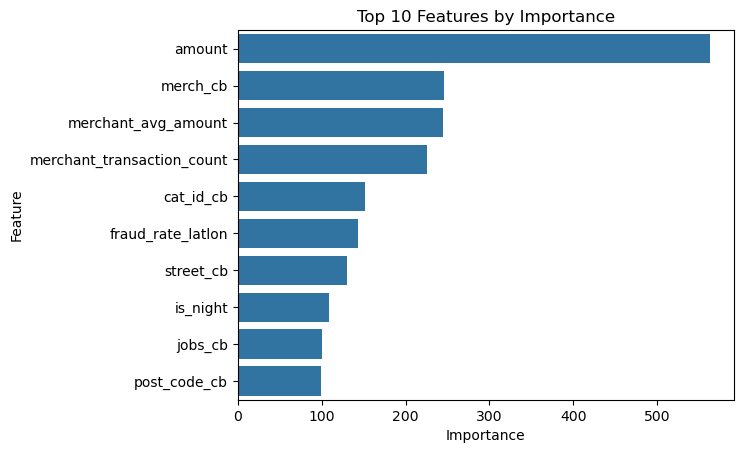

In [ ]:
# 1. Feature Importance (LightGBM)

# Получение важности признаков
importances = model.feature_importances_
feature_names = X_train[start_columns].columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Сохраняем список топ 10
top_features_fi = set(feature_importance_df.head(10)['Feature'])

# Визуализация топ-10 признаков
# plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.title('Top 10 Features by Importance')
plt.show()

In [ ]:
top_features_fi

{'amount',
 'cat_id_cb',
 'fraud_rate_latlon',
 'is_night',
 'jobs_cb',
 'merch_cb',
 'merchant_avg_amount',
 'merchant_transaction_count',
 'post_code_cb',
 'street_cb'}

In [ ]:
len(X_train.columns)

44

## 3.2 SHAP (SHapley Additive exPlanations)
SHAP использует теорию кооперативных игр для оценки вклада каждого признака в предсказания модели. Он предоставляет более детальное представление о том, как признаки влияют на выход модели, включая положительное или отрицательное воздействие.

/Users/annashestakova/anaconda3/lib/python3.11/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Форма SHAP-значений: (259523, 30)


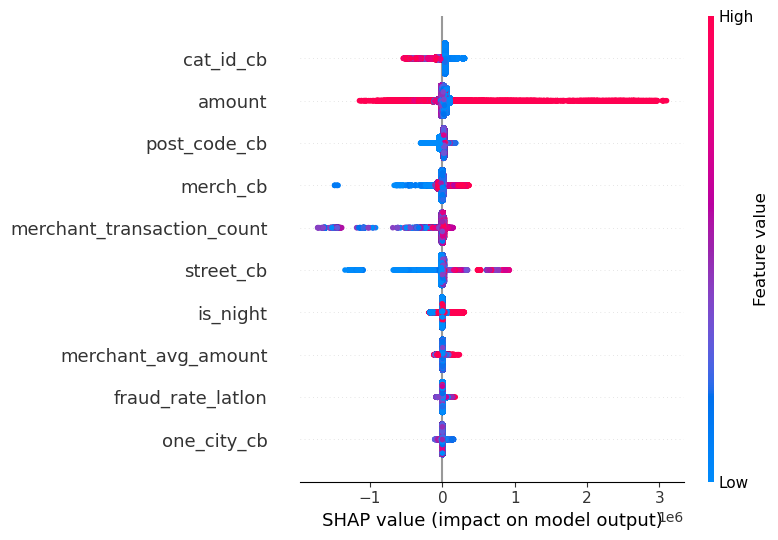

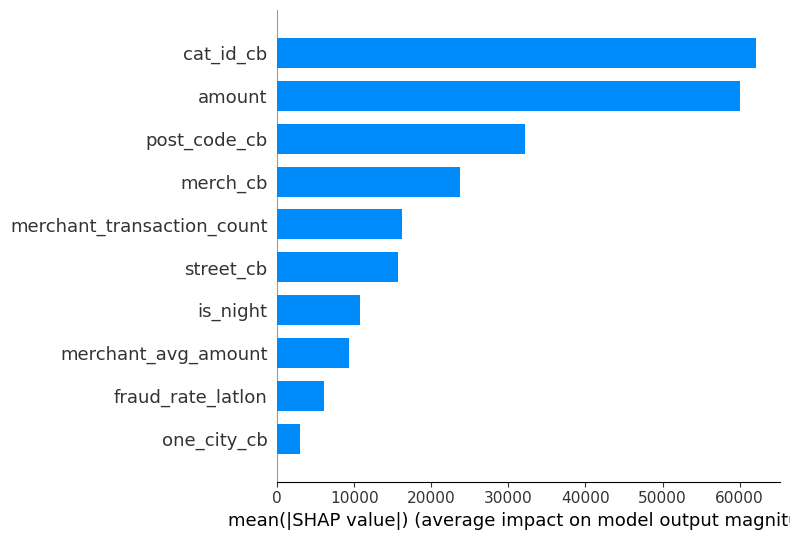

Топ-10 признаков:
                       feature  shap_importance
21                   cat_id_cb     62140.469758
0                       amount     60068.787960
29                post_code_cb     32206.450822
20                    merch_cb     23688.299486
18  merchant_transaction_count     16190.746375
25                   street_cb     15627.878063
8                     is_night     10786.918712
17         merchant_avg_amount      9333.850587
16           fraud_rate_latlon      6089.353516
26                 one_city_cb      2956.008854


In [ ]:
import shap

# Вычисление SHAP-значений
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test[start_columns])

# Для бинарной классификации LightGBM:
if isinstance(shap_values, list):
    # Берём SHAP значения для класса 1 (фрод) и преобразуем в 2D-массив
    shap_values_class1 = np.array(shap_values[1])
    # Проверяем, что это матрица (n_samples, n_features)
    if len(shap_values_class1.shape) == 1:
        shap_values_class1 = shap_values_class1.reshape(-1, 1)
else:
    shap_values_class1 = shap_values

# Проверка формы SHAP-значений
print(f"Форма SHAP-значений: {shap_values_class1.shape}")  # Должно быть (n_samples, n_features)

# Корректный расчет важности (средние |SHAP|)
shap_df = pd.DataFrame({
    'feature': X_test[start_columns].columns,
    'shap_importance': np.abs(shap_values_class1).mean(axis=0)
})

# Удаляем дубликаты и сортируем
top_features_shap = shap_df.drop_duplicates().sort_values('shap_importance', ascending=False).head(10)

# Визуализация
try:
    shap.summary_plot(shap_values_class1, X_test[start_columns], max_display=10)
    plt.title("SHAP Summary Plot (Топ-10 признаков)")
    plt.tight_layout()
    plt.savefig('shap_summary.png', dpi=300, bbox_inches='tight')
    plt.close()
except Exception as e:
    print(f"Ошибка визуализации: {e}")

# Альтернативная визуализация (bar plot)
try:
    shap.summary_plot(shap_values_class1, X_test[start_columns], plot_type='bar', max_display=10)
    plt.title("SHAP Feature Importance")
    plt.tight_layout()
    plt.savefig('shap_bar.png', dpi=300, bbox_inches='tight')
    plt.close()
except Exception as e:
    print(f"Ошибка bar plot: {e}")

print("Топ-10 признаков:")
print(top_features_shap)


In [ ]:
set_top_features_shap = set(top_features_shap['feature'])

## 3.3 Permutation Importance (Перестановочный анализ)


Permutation importance измеряет важность признака, случайным образом перемешивая его значения и оценивая, как это влияет на метрику (например, F1-score). Если перемешивание сильно ухудшает метрику, значит признак важен.

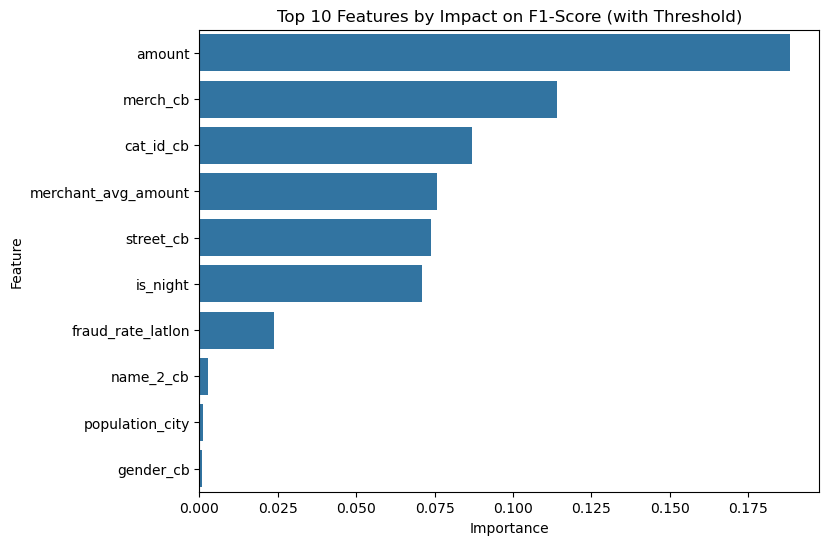

                Feature  Importance
0                amount    0.188279
20             merch_cb    0.113976
21            cat_id_cb    0.086890
17  merchant_avg_amount    0.075837
25            street_cb    0.073799
8              is_night    0.071001
16    fraud_rate_latlon    0.023877
23            name_2_cb    0.002599
3       population_city    0.001291
24            gender_cb    0.000987


In [ ]:
from sklearn.metrics import f1_score
import numpy as np

# Базовая модель и предсказания уже получены в пункте  Base model . LGBMClassifier + best_threshold:

# Получение вероятностей и бинаризация с использованием best_threshold
baseline_predictions = model.predict_proba(X_test[start_columns])[:, 1]
baseline_predictions_binary = baseline_predictions >= best_threshold
baseline_f1 = f1_score(y_test, baseline_predictions_binary)

# Словарь для хранения изменений F1-score
feature_importance = {}

# Перебираем каждый признак
for feature in X_train[start_columns].columns:
    # Копируем тестовые данные
    X_test_permuted = X_test[start_columns].copy()

    # Перемешиваем значения признака
    X_test_permuted[feature] = np.random.permutation(X_test_permuted[feature])

    # Вычисляем вероятности с перемешанным признаком
    permuted_predictions = model.predict_proba(X_test_permuted)[:, 1]

    # Бинаризуем предсказания с использованием best_threshold
    permuted_predictions_binary = permuted_predictions >= best_threshold

    # Вычисляем F1-score с перемешанным признаком
    permuted_f1 = f1_score(y_test, permuted_predictions_binary)

    # Сохраняем разницу между базовым F1 и перемешанным F1
    feature_importance[feature] = baseline_f1 - permuted_f1

# Преобразуем результаты в DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': list(feature_importance.keys()),
    'Importance': list(feature_importance.values())
}).sort_values(by='Importance', ascending=False)

top_features_perm = feature_importance_df.head(10)

# Визуализация топ-10 признаков
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.title('Top 10 Features by Impact on F1-Score (with Threshold)')
plt.show()

print(top_features_perm)

In [ ]:
set_top_features_shap = set(top_features_perm['Feature'])

In [ ]:
# Объединение всех топ-10 признаков без повторов
all_top_features = top_features_fi.union(set_top_features_shap).union(set_top_features_shap)

# Объединенный список признаков
Second_features= list(all_top_features)
len(Second_features)

13

# 5 Второе обучение модели  LGBMClassifier с отобраными признаками

In [8]:
# Второе обучение модели  LGBMClassifier


# Расчет scale_pos_weight
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Обучение модели
model = LGBMClassifier(
    random_state=42,
    objective='binary',
    metric='f1',
    max_depth=6,
    num_leaves=31,
    scale_pos_weight=scale_pos_weight
)
model.fit(X_train[Second_features], y_train)


# Получение вероятностей
predictions = model.predict_proba(X_test[Second_features])[:, 1]

# Поиск оптимального порога
precision, recall, thresholds = precision_recall_curve(y_test, predictions)
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores)]

print("Best Threshold:", best_threshold)

# Бинаризация предсказаний
predictions_binary = predictions >= best_threshold

# Оценка качества
print("F1 Score:", f1_score(y_test, predictions_binary))
print("Classification Report:\n", classification_report(y_test, predictions_binary))



Best Threshold: 1.0
F1 Score: 0.20515970515970516
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    258037
           1       0.13      0.56      0.21      1486

    accuracy                           0.98    259523
   macro avg       0.56      0.77      0.60    259523
weighted avg       0.99      0.98      0.98    259523


После отбора признаков F1 Score понизился с 0.73, до 0.66

Видимо, мы убрали часть важных признаков, которые совместно могли сильно влиять на результат. Для улучшения можно было бы придумать гибкий критерий отбора, но мы это попробуем реализовать на втором соревновании.

Попробуем улучшить гиперпараметры самой модели.

## 5.1 Подбор гиперпараметров

 Используем GridSearchCV для подбора гиперпараметров:
 Будем использовать первый набор признаков start_columns

 В процессе заменили на  RandomizedSearchCV, так как GridSearchCV в течение дня так и закончил свою работу.

In [10]:
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier

# 1. Создаем уменьшенную сетку параметров
param_grid = {
    'n_estimators': [50, 100],    # Количество деревьев
    'learning_rate': [0.05, 0.1], # Скорость обучения
    'max_depth': [3, 5],          # Максимальная глубина дерева
    'num_leaves': [15, 31],       # Максимальное количество листьев
    'subsample': [0.8, 1.0],      # Доля объектов для обучения каждого дерева
    'colsample_bytree': [0.8, 1.0],   # Доля признаков для обучения каждого дерева
    'reg_alpha': [0.0, 0.1],      # L1-регуляризация
    'reg_lambda': [0.0, 0.1],      # L2-регуляризация
    'scale_pos_weight': [1, 5, 10, 20]  # Добавляем scale_pos_weight
}


# 2. Создаем модель
model = LGBMClassifier(random_state=42, objective='binary', metric='f1')

# 3. Создаем RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=50,                  # Проверяем 50 случайных комбинаций
    scoring='f1',
    cv=3,                       # Уменьшаем количество фолдов
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# 4. Обучаем RandomizedSearchCV на данных
random_search.fit(X_train[start_columns], y_train)

# 5. Выводим лучшие параметры
print("Лучшие параметры:", random_search.best_params_)
print("Лучший F1-score на кросс-валидации:", random_search.best_score_)

Лучшие параметры: {'subsample': 0.8, 'scale_pos_weight': 1, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'num_leaves': 31, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
Лучший F1-score на кросс-валидации: 0.7777219780388412


In [ ]:
# 6. Получаем лучшую модель
best_model = random_search.best_estimator_

# 7. Оцениваем лучшую модель на тестовых данных
predictions = best_model.predict_proba(X_test[start_columns])[:, 1]

# Поиск оптимального порога
precision, recall, thresholds = precision_recall_curve(y_test, predictions)
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores)]

print("Best Threshold:", best_threshold)

# Бинаризация предсказаний
predictions_binary = predictions >= best_threshold

# Оценка F1-score на тестовых данных
print("F1 Score на тестовых данных:", f1_score(y_test, predictions_binary))

Best Threshold: 0.268832360645768
F1 Score на тестовых данных: 0.5809962327333612


В целом наверное это лучший результат.

## 5.2 Кросс-валидация на train

Проведем кросс валидацию на train,  затем сравним результаты кросс-валидации с результатами на отложенной выборке X_test.


In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_recall_curve

# Подготовка данных
X = train[start_columns]
y = train['target']

# Кросс-валидация
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scores_cv = []
best_thresholds = []  # Список для хранения оптимальных порогов

for train_index, val_index in kf.split(X, y):
    # Разделение данных на тренировочный и валидационный фолд
    X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

    # Обучение модели с найденными параметрами
    best_model = LGBMClassifier(
        random_state=42,
        objective='binary',
        metric='f1',
        subsample=1.0,
        scale_pos_weight=1,  # Используем найденное значение
        reg_lambda=0.0,
        reg_alpha=0.1,
        num_leaves=31,
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        colsample_bytree=1.0
    )
    best_model.fit(X_train_fold, y_train_fold)

    # Предсказания вероятностей на валидационном фолде
    y_val_proba = best_model.predict_proba(X_val_fold)[:, 1]

    # Поиск оптимального порога
    precision, recall, thresholds = precision_recall_curve(y_val_fold, y_val_proba)
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold = thresholds[np.argmax(f1_scores)]
    best_thresholds.append(best_threshold)  # Сохраняем оптимальный порог для текущего фолда

    # Бинаризация предсказаний
    y_val_pred = y_val_proba >= best_threshold

    # Оценка F1-score на валидационном фолде
    f1_scores_cv.append(f1_score(y_val_fold, y_val_pred))

# Средний F1-score на кросс-валидации
mean_f1_score = sum(f1_scores_cv) / len(f1_scores_cv)
mean_best_threshold = sum(best_thresholds) / len(best_thresholds)  # Средний оптимальный порог

print("Средний F1-score на кросс-валидации:", mean_f1_score)
print("Средний оптимальный порог (best threshold):", mean_best_threshold)

Средний F1-score на кросс-валидации: 0.7547596183835642
Средний оптимальный порог (best threshold): 0.34882804203366136


In [ ]:
# Средний F1-score на кросс-валидации: 0.7543604820404436

## 5.3 Подготовка прогноза и отправка результатов

In [12]:
# Подготовка данных
X = train[start_columns]
y = train['target']


# Обучение финальной модели на всем train
final_model = LGBMClassifier(
    random_state=42,
    objective='binary',
    metric='f1',
    subsample=1.0,
    scale_pos_weight=1,  # Используем найденное значение
    reg_lambda=0.0,
    reg_alpha=0.1,
    num_leaves=31,
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    colsample_bytree=1.0
)
final_model.fit(X, y)

# Предсказания для тестового набора данных
test_predictions = final_model.predict_proba(test[start_columns])[:, 1]

# Бинаризация предсказаний
best_threshold = 0.268832360645768
test_predictions_binary = test_predictions >= best_threshold

# Сохранение предсказаний в файл
submission = pd.DataFrame({'index': test.index, 'prediction': test_predictions_binary.astype(int)})
submission.to_csv('30_03_best_submission.csv', index=False)
print("Файл submission.csv успешно создан!")

Файл submission.csv успешно создан!


In [ ]:
# К сожалению эта гипотеза завела в тупик 0.505 на лидборде
# Несмотря на Средний F1-score на кросс-валидации: 0.754

# 6. Ансамбль моделей

Создадим ансамбль из нескольких моделей.
- Ансабль на реализациях градиентного бустинга, потому что они дополняют друг друга своими уникальными преимуществами:LGBMClassifier, XGBClassifier, CatBoostClassifier
- Voting - Комбинирование предсказаний нескольких моделей путем голосования.
- Soft Voting : Каждая модель выдает вероятности принадлежности к классам, и окончательное решение принимается на основе средней вероятности.


In [ ]:
# альтернативный вариант балансировки
from imblearn.over_sampling import SMOTE

# Применяем SMOTE только к обучающим данным , для балансировки данных
smote = SMOTE(random_state=42)


X_train, y_train = smote.fit_resample(X_train[start_columns], y_train)

# Теперь X_train и y_train сразу до обучения модели содержат сбалансированные данные

In [ ]:
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

models = [
    ('lgbm', LGBMClassifier(random_state=42)),
    ('xgb', XGBClassifier(random_state=42)),
    ('catboost', CatBoostClassifier(random_state=42, verbose=0))
]

ensemble = VotingClassifier(estimators=models, voting='soft')
ensemble.fit(X_train[start_columns], y_train)
y_pred_ensemble = ensemble.predict(X_test[start_columns])

print("Ensemble F1 Score:", f1_score(y_test, y_pred_ensemble))

[LightGBM] [Info] Number of positive: 523890, number of negative: 523890
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016873 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6883
[LightGBM] [Info] Number of data points in the train set: 1047780, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Ensemble F1 Score: 0.7127127127127127


0.7127 — этот результат может побить бейзлайн, но для повышения надежности модели важно провести кросс-валидацию на всем датасете train. Это позволит убедиться в стабильности ансамбля перед финальным прогнозированием тестовых данных.

## 6.1 Кросс-валидации ансамбля

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE

# Подготовка данных
X = train[start_columns]
y = train['target']

# Кросс-валидация
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scores_cv = []

for train_index, val_index in kf.split(X, y):
    # Разделение данных на тренировочный и валидационный фолд
    X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

    # Применяем SMOTE для балансировки внутри фолда
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_fold, y_train_fold)

    # Создаем ансамбль моделей
    models = [
        ('lgbm', LGBMClassifier(random_state=42)),
        ('xgb', XGBClassifier(random_state=42)),
        ('catboost', CatBoostClassifier(random_state=42, verbose=0))
    ]
    ensemble = VotingClassifier(estimators=models, voting='soft')

    # Обучение ансамбля
    ensemble.fit(X_train_resampled, y_train_resampled)

    # Предсказания на валидационном фолде
    y_val_pred = ensemble.predict(X_val_fold)

    # Оценка F1-score на валидационном фолде
    f1_scores_cv.append(f1_score(y_val_fold, y_val_pred))

# Средний F1-score на кросс-валидации
print("Средний F1-score на кросс-валидации:", sum(f1_scores_cv) / len(f1_scores_cv))

[LightGBM] [Info] Number of positive: 625541, number of negative: 625541
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034293 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6886
[LightGBM] [Info] Number of data points in the train set: 1251082, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 625541, number of negative: 625541
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 1251082, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> inits

Средний F1-score на кросс-валидации: 0.8129066136858251 выглядит очень многообещающе.

# 7. Обучение финального ансамбля и прогнозирование теста

## Это обучение в соревновании дало  скор: 0.788482

In [ ]:
import pandas as pd

# 1. Применяем SMOTE ко всему train
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# 2. Создаем финальный ансамбль
models = [
    ('lgbm', LGBMClassifier(random_state=42)),
    ('xgb', XGBClassifier(random_state=42)),
    ('catboost', CatBoostClassifier(random_state=42, verbose=0))
]
ensemble = VotingClassifier(estimators=models, voting='soft')

# 3. Обучаем ансамбль на всем train
ensemble.fit(X_resampled, y_resampled)

# 4. Прогнозируем тестовые данные
test_predictions = ensemble.predict(test[start_columns])


# Сохранение предсказаний в файл
submission = pd.DataFrame({'index': test.index, 'prediction': test_predictions})
submission.to_csv('31_03_ansamble_noroc_submission.csv', index=False)
print("Файл успешно создан!")

[LightGBM] [Info] Number of positive: 781927, number of negative: 781927
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020450 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 1563854, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Файл успешно создан!


**Это обучение в соревновании дало  скор: 0.788482.**

## 7.1 Исполльзование оптимального порога для бинарной классификации на основе кривой ROC (Receiver Operating Characteristic).

Попробую улучшить результат

In [ ]:
from sklearn.metrics import roc_curve


ensemble.fit(X_train[start_columns], y_train)

# Предсказания вероятностей ансамблем
predictions_proba = ensemble.predict_proba(X_test[start_columns])[:, 1]

# ROC-кривая
fpr, tpr, thresholds = roc_curve(y_test, predictions_proba)

# Нахождение оптимального порога
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold: {optimal_threshold}")

# Бинаризация предсказаний с использованием оптимального порога
y_pred_binary = (predictions_proba >= optimal_threshold).astype(int)

# Оценка качества
from sklearn.metrics import f1_score
print("F1 Score with optimal threshold:", f1_score(y_test, y_pred_binary))

[LightGBM] [Info] Number of positive: 523890, number of negative: 523890
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017778 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6883
[LightGBM] [Info] Number of data points in the train set: 1047780, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Optimal threshold: 0.038988042867638906
F1 Score with optimal threshold: 0.20378197997775305


Результат сильно ухудшился, но скорее всего я как-то не так считаю threshold по ROC-кривой для ансамбля.

>

# 8. AUTO ML

На последок я решила сравнить мои результаты с авто мл https://github.com/sb-ai-lab/LightAutoML/blob/master/README.md

В процессе возник нюанс -этот авто мл не поддерживает f1, поэтому попробовала использовать ROC-AUC

## 8.1. AUTO ML с подготовленным набором фичей

In [ ]:
train_data = X_train[start_columns].copy()
train_data['target'] = y_train.values  # .values для исключения проблем с индексами

In [ ]:
from sklearn.metrics import f1_score
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task


# 1. Настройка LightAutoML
task = Task("binary", metric="auc")  # Используем ROC-AUC, т.к. F1 не поддерживается напрямую
automl = TabularAutoML(
    task=task,
    timeout=600,  # Время обучения (сек)
    cpu_limit=4,  # Количество ядер
)

# 2. Обучение модели
oof_pred = automl.fit_predict(train_data, roles={"target": "target"})

# 3. Предсказание вероятностей на тестовых данных
test_proba = automl.predict(X_test).data[:, 0]  # Вероятности класса 1 (фрод)

# 4. Подбор оптимального порога для F1
thresholds = np.linspace(0, 1, 100)
f1_scores = [f1_score(y_test, test_proba >= t) for t in thresholds]
best_threshold = thresholds[np.argmax(f1_scores)]

print(f"Лучший порог: {best_threshold:.3f}")
print(f"F1-score: {max(f1_scores):.4f}")

Лучший порог: 0.808
F1-score: 0.7596


### Спрогозируем таргет для test

In [ ]:
# 1. Подготовка данных
# Используем весь train для обучения
train_data = train[start_columns].copy()
train_data['target'] = train['target'].values  # Добавляем целевую переменную

# Тестовые данные
test_data = test[start_columns]

# 2. Настройка LightAutoML
task = Task("binary", metric="auc")  # Используем ROC-AUC, т.к. F1 не поддерживается напрямую
automl = TabularAutoML(
    task=task,
    timeout=600,  # Время обучения (сек)
    cpu_limit=4,  # Количество ядер
)

# 3. Обучение модели на всем train
oof_pred = automl.fit_predict(train_data, roles={"target": "target"})

# 4. Предсказание вероятностей на тестовых данных
test_proba = automl.predict(test_data).data[:, 0]  # Вероятности класса 1 (фрод)

# 5. Бинаризация предсказаний с использованием оптимального порога
# best_threshold оптимальный порог, найденный ранее
test_predictions_binary = test_proba >= best_threshold

# 6. Сохранение результатов
test['predicted_target'] = test_predictions_binary.astype(int)  # Добавляем предсказания в тестовый датасет

# # 7. Вывод результатов
# print("Проверка предсказаний:")
# print(test[['predicted_target']].head())

# Создаем DataFrame с колонками index, prediction
submission = pd.DataFrame({
    'index': test.index,  # Берем индексы из тестового датасета
    'prediction': test_predictions_binary.astype(int)
})

# Сохраняем в CSV (без индекса, чтобы не было дублирования)
submission.to_csv('1_auto_predictions.csv', index=False)

  **Cейчас это обучение в соревновании дало Счет: 0.728110**
  
Хороший проходной скор, но ниже чем у моего ансамбля. При этом обучение auto ML производилось на уже подготовленных фичах. А что если отправить датасет как есть?

## 8.2. AUTO ML на исходном X_train и train (без обработки)

In [ ]:
path_files = '/Users/annashestakova/Documents/ШАД МТС/МЛ 1/Соревнования/'

train = pd.read_csv(path_files + 'train_1.csv')
test = pd.read_csv(path_files + 'test_1.csv')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    train.drop('target', axis=1),
    train['target'],
    test_size=0.33,
    random_state=42,
    stratify=train['target']
)

In [ ]:
train_data = X_train.copy()
train_data['target'] = y_train.values  # .values для исключения проблем с индексами

In [ ]:
# 1. Настройка LightAutoML
task = Task("binary", metric="auc")  # Используем ROC-AUC, т.к. F1 не поддерживается напрямую
automl = TabularAutoML(
    task=task,
    timeout=600,  # Время обучения (сек)
    cpu_limit=4,  # Количество ядер
)

# 2. Обучение модели
oof_pred = automl.fit_predict(train_data, roles={"target": "target"})

# 3. Предсказание вероятностей на тестовых данных
test_proba = automl.predict(X_test).data[:, 0]  # Вероятности класса 1 (фрод)

# 4. Подбор оптимального порога для F1
thresholds = np.linspace(0, 1, 100)
f1_scores = [f1_score(y_test, test_proba >= t) for t in thresholds]
best_threshold = thresholds[np.argmax(f1_scores)]

print(f"Лучший порог: {best_threshold:.3f}")
print(f"F1-score: {max(f1_scores):.4f}")

Лучший порог: 0.202
F1-score: 0.5685


In [ ]:
# Получаем вероятности для класса 1 (фрод) на реальном тесте
test_proba_final = automl.predict(test).data[:, 0]  # Вероятности

In [ ]:
# 2. Преобразование в бинарные предсказания (0/1)
# Используем найденный оптимальный порог (0.101):
binary_predictions = (test_proba_final > best_threshold).astype(int)  # 1 и 0

In [ ]:
# Создаем DataFrame с колонками index, prediction
submission = pd.DataFrame({
    'index': test.index,  # Берем индексы из тестового датасета
    'prediction': binary_predictions
})

# Сохраняем в CSV (без индекса, чтобы не было дублирования)
submission.to_csv('1_all_auto_predictions.csv', index=False)

# Оценка в совревновании : 0.524850

In [ ]:
# Оценка в совревновании : 0.524850

In [ ]:
Лучшее  обучение в соревновании дало скор: 0.788482.
Ансамбль из LGBMClassifier, XGBClassifier и CatBoostClassifier

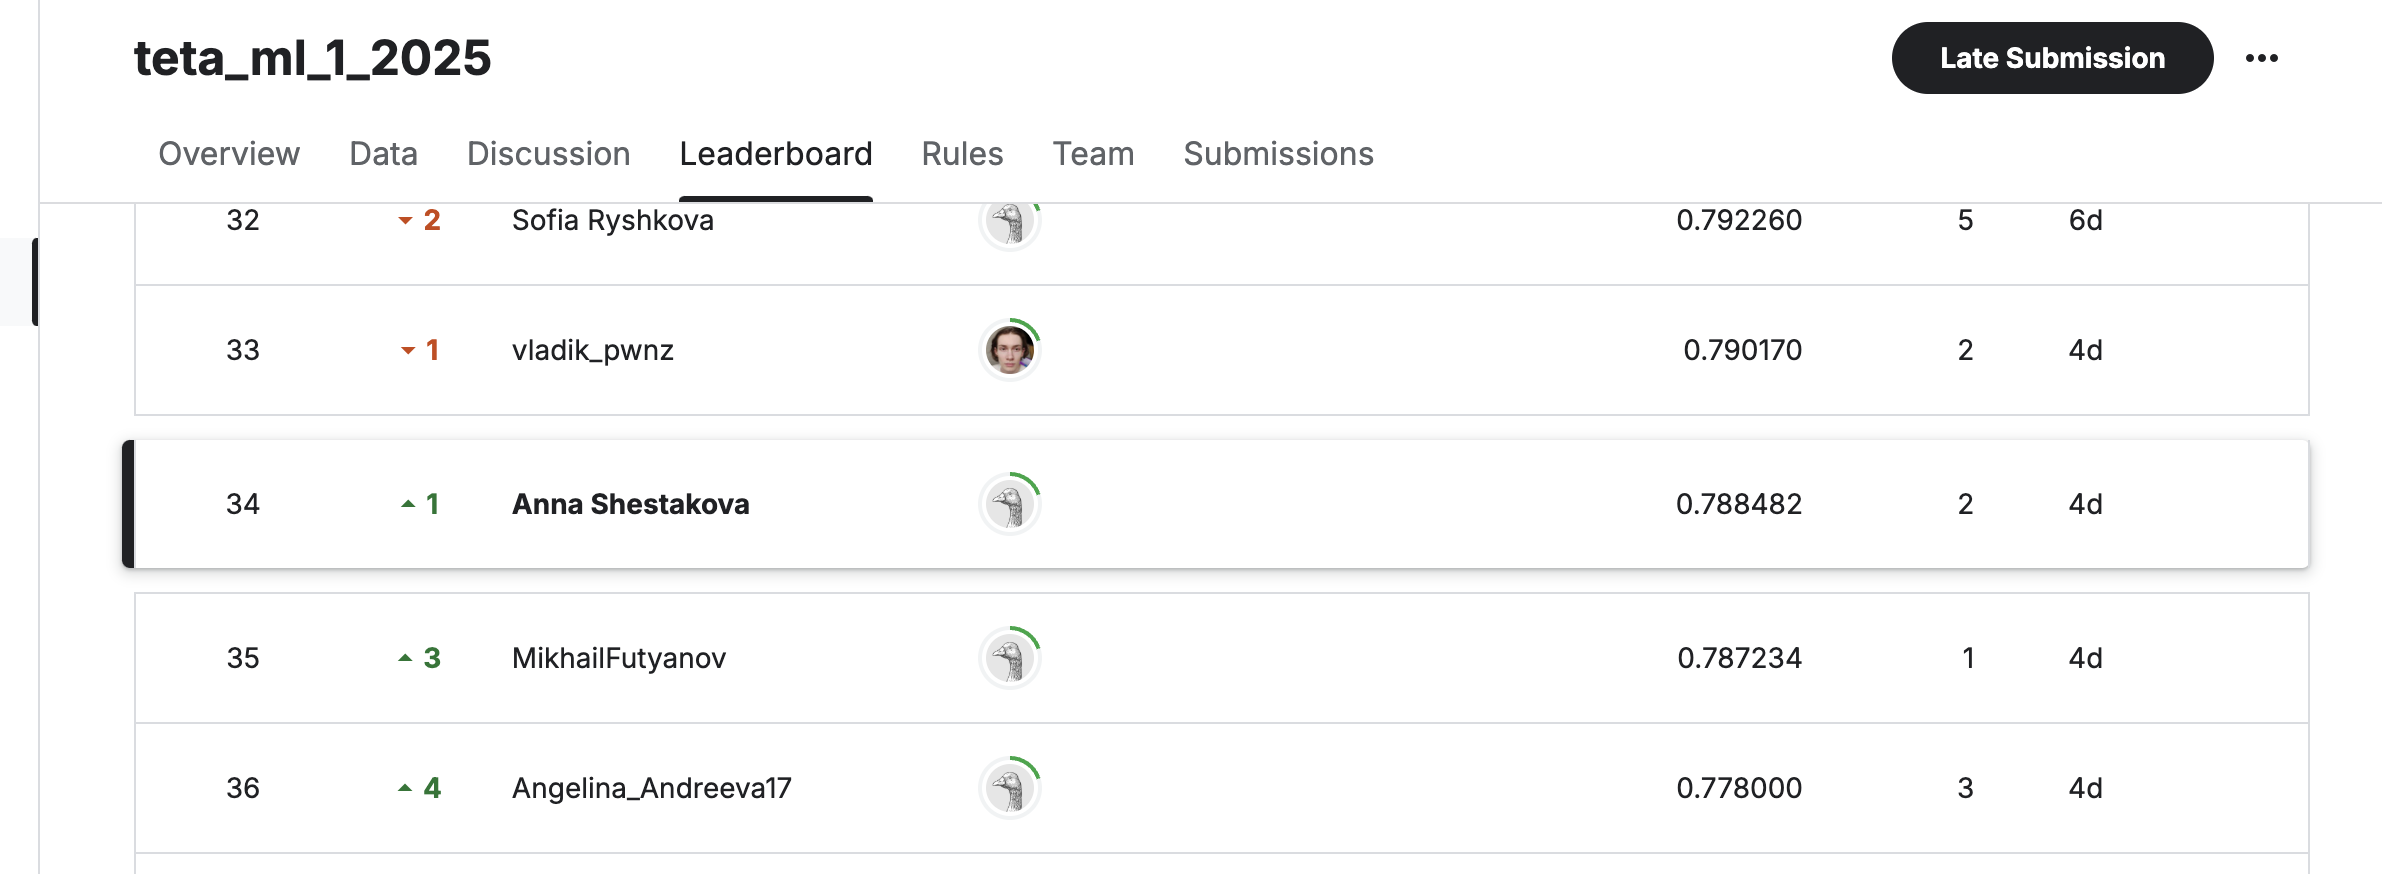